In [1]:
import numpy as np
from cluster_data import ClusterData, cluster_data_to_array, normalize_data, estimate_runtime
from kmeans import k_means
from my_kmedoids import pam_clustering
from fuzzy_c_means import fuzzy_c_means
import my_kmedoids
from DBSCAN import dbscan_clustering

def main():
    #Example data: list of ClusterData (3 dimensions: inc, raan, ecc)
    data_list = [
        ClusterData(inc=10.0, raan=20.0),
        ClusterData(inc=12.0, raan=22.0),
        ClusterData(inc=11.0, raan=21.0),
        ClusterData(inc=50.0, raan=60.0),
        ClusterData(inc=52.0, raan=62.0),
        ClusterData(inc=51.0, raan=61.0),
    ]
    
    # Convert the list of named tuples to a numpy array.
    data_array = cluster_data_to_array(data_list)
    
    # Normalize the data.
    normalized_data, data_min, data_max = normalize_data(data_array) 
    k = 2  # Number of clusters
    
    # --- K-means Clustering ---
    print("\nK-means result:")
    result_kmeans, time_kmeans = estimate_runtime(k_means, normalized_data, k, init='random')
    print("Labels:", result_kmeans.labels)
    print("Cluster centers:\n", result_kmeans.cluster_centers)
                                                      
    # --- Fuzzy C-means Clustering ---
    print("\nFuzzy C-means result:")
    result_fcm, time_fcm = estimate_runtime(fuzzy_c_means, normalized_data, k, m=2)
    print("Labels:", result_fcm.labels)
    print("Cluster centers:\n", result_fcm.cluster_centers)                                          

    # --- K-medoids (PAM) Clustering ---
    print("\nK-medoids (PAM) result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, build_function=None, swap_function=None)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers)
    
    # --- K-medoids (PAM) Clustering --- FastPAM2 and LAB Build
    print("\nK-medoids fastPAM2 + LAB-build result:")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, my_kmedoids.fastpam_lab_build, my_kmedoids.fastpam2_swap)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers)

    print("\nDBSCAN result:")
    result_dbscan, time_dbscan = estimate_runtime(dbscan_clustering, normalized_data, eps=0.5, min_samples=5)
    print(result_dbscan)
    print("Labels:", result_dbscan.labels)
    print("Cluster centers:\n", result_dbscan.cluster_centers)

    # --- K-medoids (PAM) Clustering --- FastPAM1
    print("\nK-medoids fastPAM 1 result:")
    print(normalized_data.shape, "here")
    result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, build_function=None, swap_function=my_kmedoids.fastpam1_swap)
    #result_kmedoids, time_kmedoids = estimate_runtime(pam_clustering, normalized_data, k, None, my_kmedoids.fastpam1_swap)
    print("Labels:", result_kmedoids.labels)
    print("Cluster centers:\n", result_kmedoids.cluster_centers) 

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

args received in run_clustering: (), type: <class 'tuple'>

Mean Shift result:


Running Mean Shift:   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)


Running Mean Shift:  67%|██████▋   | 2/3 [00:04<00:01,  1.71s/step]

Runtime for mean_shift_clustering: 3.864076 seconds
Processing cluster 0 with 1976 points
Cluster 0: hull area = 0.130843571732639, density = 15102.002901890255
Processing cluster 1 with 622 points
Cluster 1: hull area = 0.14317301059577892, density = 4344.394222149143
Processing cluster 2 with 184 points
Cluster 2: hull area = 0.19775775259934622, density = 930.4312856587767
Processing cluster 3 with 6 points
Cluster 3: hull area = 0.0025631715423969446, density = 2340.849959027367


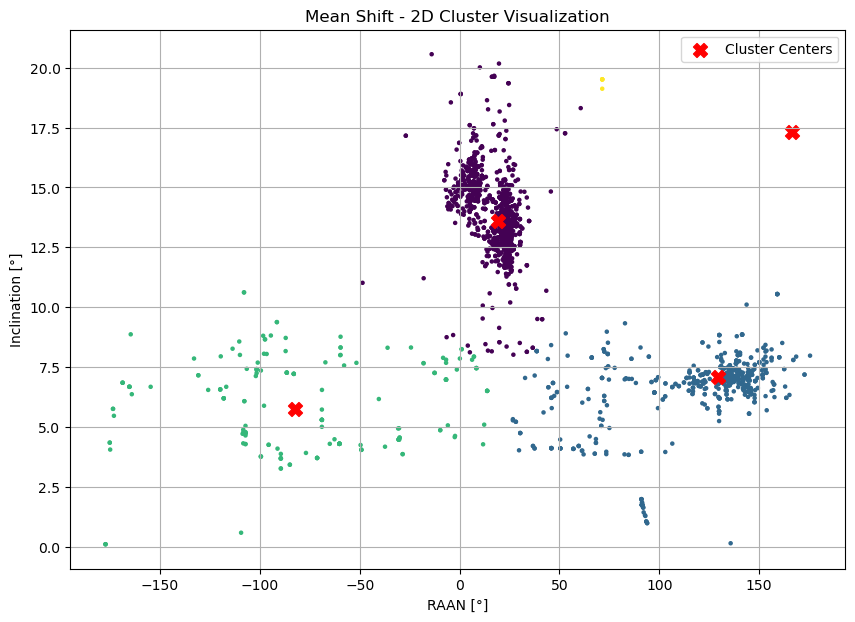

Running Mean Shift: 100%|██████████| 3/3 [00:04<00:00,  1.43s/step]


args received in run_clustering: (4,), type: <class 'tuple'>

K-means result:


Running K-means:  67%|██████▋   | 2/3 [00:00<00:00, 11.49step/s]

Data shape before clustering: (2788, 2)
Runtime for k_means: 0.017392 seconds
Processing cluster 0 with 587 points
Cluster 0: hull area = 0.09813167885763883, density = 5981.758457954949
Processing cluster 1 with 179 points
Cluster 1: hull area = 0.194139751594344, density = 922.0162204287838
Processing cluster 2 with 617 points
Cluster 2: hull area = 0.14151450047376796, density = 4359.977231551414
Processing cluster 3 with 1405 points
Cluster 3: hull area = 0.05524448872609765, density = 25432.401175183186


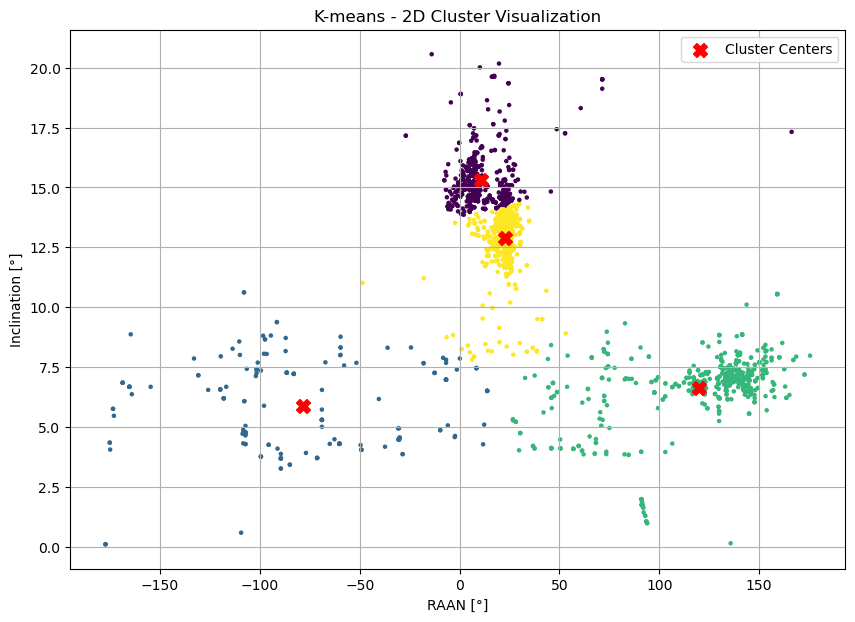

Running K-means: 100%|██████████| 3/3 [00:00<00:00,  8.81step/s]


args received in run_clustering: (4,), type: <class 'tuple'>

Fuzzy C-means result:


Running Fuzzy C-means:   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)


Running Fuzzy C-means:  67%|██████▋   | 2/3 [00:06<00:02,  2.62s/step]

Runtime for fuzzy_c_means: 6.105089 seconds
Processing cluster 0 with 1394 points
Cluster 0: hull area = 0.05505713047261928, density = 25319.154631446996
Processing cluster 1 with 616 points
Cluster 1: hull area = 0.13976522266746497, density = 4407.391110917571
Processing cluster 2 with 179 points
Cluster 2: hull area = 0.194139751594344, density = 922.0162204287838
Processing cluster 3 with 599 points
Cluster 3: hull area = 0.09944597329832963, density = 6023.3710841468655


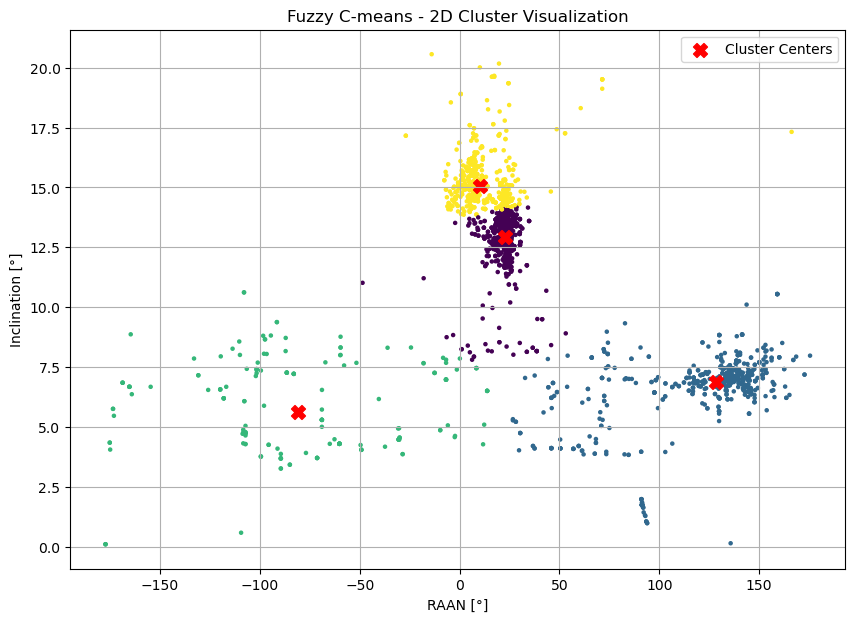

Running Fuzzy C-means: 100%|██████████| 3/3 [00:06<00:00,  2.18s/step]


args received in run_clustering: (4,), type: <class 'tuple'>

K-medoids (PAM) result:


Running K-medoids (PAM):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)
<function pam_build at 0x00000197AFF2BEC0> <function pam_swap at 0x00000197B04C77E0>
Data shape at the start of pam_clustering: (2788, 2)
(4,)
Initial medoids: [1245, 175, 129, 1430]
[1245  175  129 1430] medoids
[1204, 175, 129, 1430] medoids


Running K-medoids (PAM):  67%|██████▋   | 2/3 [44:53<18:29, 1109.21s/step]  

Final medoids (indices): [1204  175  129 1430]
Medoids after selecting data points: (4, 2)
Distances shape: (2788, 4)
Labels shape: (2788,)
Runtime for pam_clustering: 2693.560759 seconds
Processing cluster 0 with 1399 points
Cluster 0: hull area = 0.10775504981027449, density = 12983.150232524924
Processing cluster 1 with 608 points
Cluster 1: hull area = 0.1353589000958627, density = 4491.762267345609
Processing cluster 2 with 193 points
Cluster 2: hull area = 0.20931324687597025, density = 922.0629983078102
Processing cluster 3 with 588 points
Cluster 3: hull area = 0.06327437177137504, density = 9292.861920851306


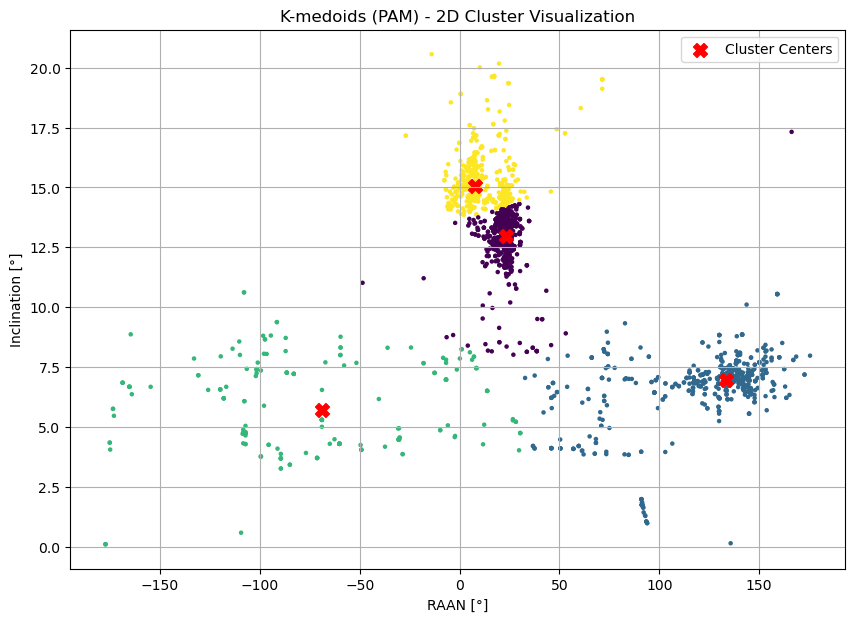

Running K-medoids (PAM): 100%|██████████| 3/3 [44:53<00:00, 897.99s/step] 


Data shape before clustering: (2788, 2)


TypeError: dbscan_clustering() got an unexpected keyword argument 'plot'

In [ ]:
import numpy as np
import cluster_data
import my_kmedoids
from cluster_plotter import ClusterPlotter
from kmeans import k_means
from fuzzy_c_means import fuzzy_c_means
from my_kmedoids import pam_clustering
from DBSCAN import dbscan_clustering
from mean_shift import mean_shift_clustering
import scores
import pandas as pd
from cluster_data import run_clustering

# Load and preprocess data
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)
k = 4  # Number of clusters

list_alg = ["K - Means", "Fuzzy C Means", "K - Medoids", "DBSCAN", "K-medoids fastPAM2 + LAB-build", "FAST PAM 1"]

# Run clustering algorithms
result_mean_shift, time_mean_shift, n_clusters_mean_shift, points_per_cluster_mean_shift, metrics_mean_shift = run_clustering(mean_shift_clustering, "Mean Shift", normalized_data, data_min, data_max, plot = True, bandwidth = 0.2)
result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(k_means, "K-means", normalized_data, data_min, data_max, k, plot = True, init='kmeans++')
result_fcm, time_fcm, n_clusters_fcm, points_per_cluster_fcm, metrics_fcm = run_clustering(fuzzy_c_means, "Fuzzy C-means", normalized_data, data_min, data_max, k, plot = True, m=2)
result_kmedoids, time_kmedoids, n_clusters_kmedoids, points_per_cluster_kmedoids, metrics_kmedoids = run_clustering(pam_clustering, "K-medoids (PAM)", normalized_data, data_min, data_max, k, plot = True, build_function=None, swap_function=None)
result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = cluster_data.estimate_runtime(dbscan_clustering, normalized_data, eps=0.5, min_samples=5, plot = True)
result_fastpam2, time_fastpam2, n_clusters_fastpam2, points_per_cluster_fastpam2, metrics_fastpam2 = run_clustering(pam_clustering, "K-medoids fastPAM2 + LAB-build", normalized_data, data_min, data_max, k, plot = True, build_function = my_kmedoids.fastpam_lab_build, swap_function = my_kmedoids.fastpam2_swap)
result_fastpam1, time_fastpam1, n_clusters_fastpam1, points_per_cluster_fastpam1, metrics_fastpam1 = run_clustering(pam_clustering, "K-medoids fastPAM1", normalized_data, data_min, data_max, k, plot = True, build_function = None, swap_function = my_kmedoids.fastpam1_swap)

runtimes = [time_mean_shift, time_kmeans, time_fcm, time_kmedoids, time_dbscan, time_fastpam2, time_fastpam1]
n_clusters = [n_clusters_mean_shift, n_clusters_kmeans, n_clusters_fcm, n_clusters_kmedoids, n_clusters_dbscan, n_clusters_fastpam2, n_clusters_fastpam1]
points_per_clusters = [points_per_cluster_mean_shift, points_per_cluster_kmeans, points_per_cluster_fcm, points_per_cluster_kmedoids, points_per_cluster_dbscan, points_per_cluster_fastpam2, points_per_cluster_fastpam1]

metrics = [metrics_mean_shift, metrics_kmeans, metrics_fcm, metrics_kmedoids, metrics_dbscan, metrics_fastpam2, metrics_fastpam1]
DB_scores = [m[0] for m in metrics]
CH_scores = [m[1] for m in metrics]
dunn_index = [m[2] for m in metrics]
sil_scores = [m[3] for m in metrics]
cluster_2d_std = [m[4] for m in metrics]
square_density = [m[5] for m in metrics]
hull_density = [m[6] for m in metrics]

print("\n--- Runtime Summary ---")
print(f"K-means runtime: {time_kmeans:.6f} seconds")
print(f"Fuzzy C-means runtime: {time_fcm:.6f} seconds")
print(f"K-medoids (PAM) runtime: {time_kmedoids:.6f} seconds")
print(f"DBSCAN runtime: {time_dbscan:.6f} seconds")
print(f"K-medoids fastPAM2 + LAB-build runtime: {time_fastpam2:.6f} seconds")
print(f"K-medoids fastPAM1 runtime: {time_fastpam1:.6f} seconds")

# Unnormalize DBSCAN results
unnormalized_data = cluster_data.unnormalize(normalized_data, None, data_min, data_max)[0]

# Collect all metrics in a list of dictionaries
clustering_results = {
    "Algorithm": ["Mean Shift", "K-means", "Fuzzy C-means", "K-medoids (PAM)", "DBSCAN", "K-medoids fastPAM2 + LAB-build", "K-medoids fastPAM1"],
    "Clusters": n_clusters,
    "Davies-Bouldin": DB_scores,
    "Silhouette": sil_scores,
    "Calinski-Harabasz": CH_scores,
    "Dunn Index": dunn_index,
    "Runtime (s)": runtimes
}

df_results = pd.DataFrame(clustering_results)
df_results.to_csv("clustering_results.csv", index=False)
print("\nClustering results have been saved to 'clustering_results.csv'")


In [ ]:
result_fastpam2, time_fastpam2, n_clusters_fastpam2, points_per_cluster_fastpam2, metrics_fastpam2 = run_clustering(pam_clustering, "K-medoids fastPAM2 + LAB-build", normalized_data, data_min, data_max, k, plot = True, build_function = my_kmedoids.fastpam_lab_build, swap_function = my_kmedoids.fastpam2_swap)
result_fastpam1, time_fastpam1, n_clusters_fastpam1, points_per_cluster_fastpam1, metrics_fastpam1 = run_clustering(pam_clustering, "K-medoids fastPAM1", normalized_data, data_min, data_max, k, plot = True, build_function = None, swap_function = my_kmedoids.fastpam1_swap)

args received in run_clustering: (4,), type: <class 'tuple'>

K-medoids fastPAM2 + LAB-build result:


Running K-medoids fastPAM2 + LAB-build:   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)
<function fastpam_lab_build at 0x00000197AFF3C680> <function fastpam2_swap at 0x00000197B0538220>
Data shape at the start of pam_clustering: (2788, 2)
Initial medoids: [1218, 252, 2066, 1299]
Before swap function, medoids: [1218  252 2066 1299], type: <class 'numpy.ndarray'>


Running K-medoids fastPAM2 + LAB-build:   0%|          | 0/3 [46:39<?, ?step/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import kmeans
import clustering_utils
import cluster_data

#first round: initialization with initial guess
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)
k = 2

num_trials = 1000
distortions = []

for _ in range(num_trials):
    result_kmeans, _ = cluster_data.run_clustering(kmeans.k_means, "K-means", normalized_data, data_min, data_max, k, plot=False)
    distortion = kmeans.compute_distortion(result_kmeans)
    distortions.append(distortion)

# Compute statistics for different numbers of runs
num_runs_list = np.arange(1, num_trials + 1)
means = [np.mean(distortions[:i]) for i in num_runs_list]
stds = [np.std(distortions[:i]) for i in num_runs_list]
variances = [np.var(distortions[:i]) for i in num_runs_list]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_runs_list, means, label='Mean Distortion', color='blue')
plt.plot(num_runs_list, stds, label='Standard Deviation', color='red')
plt.plot(num_runs_list, variances, label='Variance', color='green')

plt.xlabel("Number of Runs")
plt.ylabel("Distortion / Std / Variance")
plt.title("Dependence of K-means Results on Initialization, random initilization")
plt.legend()
plt.grid()
plt.show()

#second round: initilization with kmeans++

num_trials = 1000
distortions = []

for _ in range(num_trials):
    result_kmeans, _ = cluster_data.run_clustering(kmeans.k_means, "K-means", normalized_data, data_min, data_max, k, plot=False, init = "kmeans++")
    distortion = kmeans.compute_distortion(result_kmeans)
    distortions.append(distortion)

# Compute statistics for different numbers of runs
num_runs_list = np.arange(1, num_trials + 1)
means = [np.mean(distortions[:i]) for i in num_runs_list]
stds = [np.std(distortions[:i]) for i in num_runs_list]
variances = [np.var(distortions[:i]) for i in num_runs_list]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(num_runs_list, means, label='Mean Distortion', color='blue')
plt.plot(num_runs_list, stds, label='Standard Deviation', color='red')
plt.plot(num_runs_list, variances, label='Variance', color='green')

plt.xlabel("Number of Runs")
plt.ylabel("Distortion / Std / Variance")
plt.title("Dependence of K-means Results on Initialization, kmeans++ initialization")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
import cluster_data
import my_kmedoids
from cluster_plotter import ClusterPlotter
from kmeans import k_means
from fuzzy_c_means import fuzzy_c_means
from my_kmedoids import pam_clustering
from DBSCAN import dbscan_clustering
from mean_shift import mean_shift_clustering
import scores
import pandas as pd
from cluster_data import run_clustering
from multiprocessing import Pool

# Load and preprocess data
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)
k = 4  # Number of clusters

list_alg = ["K - Means", "Fuzzy C Means", "FAST PAM 1", "FAST PAM 2", "K - Medoids", "DBSCAN", "K-medoids fastPAM2 + LAB-build"]

# Define a function for parallel execution
def run_algorithm(params):
    algo_name, func, kwargs = params
    if algo_name == "DBSCAN":
        return algo_name, cluster_data.estimate_runtime(func, **kwargs)
    else:
        return algo_name, run_clustering(func, **kwargs)

# List of clustering algorithms and their parameters
algorithms = [
    ("Mean Shift", mean_shift_clustering, {"normalized_data": normalized_data, "data_min": data_min, "data_max": data_max, "plot": True, "bandwidth": 0.2}),
    ("K-means", k_means, {"normalized_data": normalized_data, "data_min": data_min, "data_max": data_max, "k": k, "plot": True, "init": "kmeans++"}),
    ("Fuzzy C-means", fuzzy_c_means, {"normalized_data": normalized_data, "data_min": data_min, "data_max": data_max, "k": k, "plot": True, "m": 2}),
    ("K-medoids fastPAM1", pam_clustering, {"normalized_data": normalized_data, "data_min": data_min, "data_max": data_max, "k": k, "plot": True, "build_function": None, "swap_function": my_kmedoids.fastpam1_swap}),
    ("K-medoids (PAM)", pam_clustering, {"normalized_data": normalized_data, "data_min": data_min, "data_max": data_max, "k": k, "plot": True, "build_function": None, "swap_function": None}),
    ("DBSCAN", dbscan_clustering, {"normalized_data": normalized_data, "eps": 0.5, "min_samples": 5, "plot": True}),
    ("K-medoids fastPAM2 + LAB-build", pam_clustering, {"normalized_data": normalized_data, "data_min": data_min, "data_max": data_max, "k": k, "plot": True, "build_function": my_kmedoids.fastpam_lab_build, "swap_function": my_kmedoids.fastpam2_swap}),
]

# Run clustering algorithms in parallel
with Pool(processes=4) as pool:  # Adjust number of processes to your available cores
    results = pool.map(run_algorithm, algorithms)

# Collect results
metrics = {}
for algo_name, (result, runtime, n_clusters, points_per_cluster, metric_values) in results:
    metrics[algo_name] = {
        "Runtime (s)": runtime,
        "Clusters": n_clusters,
        "Davies-Bouldin": metric_values[0],
        "Silhouette": metric_values[3],
        "Calinski-Harabasz": metric_values[1],
        "Dunn Index": metric_values[2],
    }

# Convert results to DataFrame
df_results = pd.DataFrame.from_dict(metrics, orient="index")
df_results.to_csv("clustering_results.csv", index=True)
print("\nClustering results have been saved to 'clustering_results.csv'")


# Vergleich der Initialisierungen:

### Zufällige Initialisierung:
Stärkere Schwankungen am Anfang, da zufällige Startwerte manchmal zu sehr schlechten Clustering-Ergebnissen führen.
Längere Konvergenzzeit, weil schlechte Startpunkte öfter auftreten.

### kmeans++-Initialisierung:
Glatterer Verlauf von Anfang an, da kmeans++ intelligentere Startwerte wählt.
Stabilisiert sich schneller, weil extreme Verzerrungen seltener auftreten.

Der wesentliche Unterschied zwischen den Methoden liegt also in der Geschwindigkeit der Konvergenz und der Stabilität der Clustering-Ergebnisse.

## KMeans with different k: Test with crossing data

In [6]:
import numpy as np
import os
import cluster_data
import my_kmedoids
from cluster_plotter import ClusterPlotter
from kmeans import k_means
from fuzzy_c_means import fuzzy_c_means
from my_kmedoids import pam_clustering
from DBSCAN import dbscan_clustering
from mean_shift import mean_shift_clustering
import scores
import pandas as pd
from IPython.display import display
from cluster_data import run_clustering
import cluster_plotter

# Create a directory for plots if it doesn't exist
plot_dir = "k_means_tests"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

# Load and preprocess data
testfile = r"../input/stat_Master_02_geo_s1.crs"
data = cluster_data.prepare_data_for_clustering(testfile)
data = np.array(data).T
normalized_data, data_min, data_max = cluster_data.normalize_data(data)

# Define the k values to iterate over
k_values = [3, 4, 5, 6, 7]

# Store results for different k values
results = []

for k in k_values:
    result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(
        k_means, f"K-means (k={k})", normalized_data, data_min, data_max, k, plot=False, init='kmeans++'
    )

    # Save the plot to the folder instead of displaying it
    unnormalized_data, cluster_centers = cluster_data.unnormalize(
        result_kmeans.data, result_kmeans.cluster_centers, data_min, data_max
    )
    plotter = ClusterPlotter(unnormalized_data, result_kmeans.labels, cluster_centers)
    plot_filename = os.path.join(plot_dir, f"kmeans_k{k}.png")
    title = f"k-Means with k = {k}"
    plotter.clusters_2d_plot(title, plot_filename)

    rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_kmeans[4].items()}
    rounded_square_density = {key: round(value, 3) for key, value in metrics_kmeans[5].items()}
    rounded_hull_density = {key: round(value, 3) for key, value in metrics_kmeans[6].items()}

    results.append({
    "k": k,
    "Runtime (s)": f"{time_kmeans:.3f}",
    "Clusters": n_clusters_kmeans,
    "Points per Cluster": points_per_cluster_kmeans,
    "Davies-Bouldin": f"{metrics_kmeans[0]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[0], (int, float)) else None,
    "Calinski-Harabasz": f"{metrics_kmeans[1]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[1], (int, float)) else None,
    "Dunn Index": f"{metrics_kmeans[2]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[2], (int, float)) else None,
    "Silhouette Score": f"{metrics_kmeans[3]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[3], (int, float)) else None,
    "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
    "Square Density": rounded_square_density if rounded_square_density else None,
    "Hull Density": rounded_hull_density if rounded_hull_density else None
})

df = pd.DataFrame(results)
numeric_cols = ["Runtime (s)", "Davies-Bouldin", "Calinski-Harabasz", 
                "Dunn Index", "Silhouette Score", "Cluster Std.", 
                "Square Density", "Hull Density"]

df[numeric_cols] = df[numeric_cols].applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)
styled_df = df.style.set_properties(**{
    'text-align': 'center',
    'width': '150px'  # Adjust column width
}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('background-color', '#f4f4f4')]}
])
display(styled_df)

#store to file with
with open("clustering_results.tex", "w") as f:
    f.write(df.to_latex(index=False, float_format="%.3f", column_format="|c|c|c|c|c|c|c|c|c|c|"))

args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3): 100%|██████████| 3/3 [00:00<00:00, 18.34step/s]

Data shape before clustering: (2788, 2)
Runtime for k_means: 0.000000 seconds
Processing cluster 0 with 1974 points
Cluster 0: hull area = 0.21048730683879133, density = 9378.23771725985
Processing cluster 1 with 627 points
Cluster 1: hull area = 0.1455797406306836, density = 4306.917963198021
Processing cluster 2 with 187 points
Cluster 2: hull area = 0.20061215850253147, density = 932.1468917729645


Plot saved as: k_means_tests\kmeans_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)
Runtime for k_means: 0.011150 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:00<00:00, 13.07step/s]

Processing cluster 0 with 1405 points
Cluster 0: hull area = 0.05524448872609765, density = 25432.401175183186
Processing cluster 1 with 179 points
Cluster 1: hull area = 0.194139751594344, density = 922.0162204287838
Processing cluster 2 with 587 points
Cluster 2: hull area = 0.09813167885763883, density = 5981.758457954949
Processing cluster 3 with 617 points
Cluster 3: hull area = 0.14151450047376796, density = 4359.977231551414


Plot saved as: k_means_tests\kmeans_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)
Runtime for k_means: 0.014061 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:00<00:00,  9.67step/s]

Processing cluster 0 with 192 points
Cluster 0: hull area = 0.08819859974868711, density = 2176.905308554607
Processing cluster 1 with 482 points
Cluster 1: hull area = 0.07428826150076953, density = 6488.239060420159
Processing cluster 2 with 1399 points
Cluster 2: hull area = 0.03878144626458125, density = 36073.951199640906
Processing cluster 3 with 149 points
Cluster 3: hull area = 0.16533651179664494, density = 901.1923523780521
Processing cluster 4 with 566 points
Cluster 4: hull area = 0.09732970817156643, density = 5815.285082354221


Plot saved as: k_means_tests\kmeans_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)
Runtime for k_means: 0.017308 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:00<00:00,  9.98step/s]

Processing cluster 0 with 1399 points
Cluster 0: hull area = 0.03878144626458125, density = 36073.951199640906
Processing cluster 1 with 482 points
Cluster 1: hull area = 0.07428826150076953, density = 6488.239060420159
Processing cluster 2 with 70 points
Cluster 2: hull area = 0.06308480914004376, density = 1109.6173699218937
Processing cluster 3 with 192 points
Cluster 3: hull area = 0.08819859974868711, density = 2176.905308554607
Processing cluster 4 with 566 points
Cluster 4: hull area = 0.09732970817156643, density = 5815.285082354221
Processing cluster 5 with 79 points
Cluster 5: hull area = 0.07304346735049522, density = 1081.547780596486


Plot saved as: k_means_tests\kmeans_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2788, 2)
Runtime for k_means: 0.034892 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:00<00:00, 12.05step/s]

Processing cluster 0 with 123 points
Cluster 0: hull area = 0.06621153889212271, density = 1857.6822417675826
Processing cluster 1 with 147 points
Cluster 1: hull area = 0.15303392752407677, density = 960.5713084562411
Processing cluster 2 with 484 points
Cluster 2: hull area = 0.04362503976371844, density = 11094.54576136633
Processing cluster 3 with 539 points
Cluster 3: hull area = 0.01863938728277785, density = 28917.259554879114
Processing cluster 4 with 1370 points
Cluster 4: hull area = 0.03030171070119388, density = 45211.96883930459
Processing cluster 5 with 50 points
Cluster 5: hull area = 0.04720781924711628, density = 1059.1465735425659
Processing cluster 6 with 75 points
Cluster 6: hull area = 0.03691060187209909, density = 2031.9365221918226


Plot saved as: k_means_tests\kmeans_k7.png


C:\Users\fionu\AppData\Local\Temp\ipykernel_18316\3612561627.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[numeric_cols] = df[numeric_cols].applymap(lambda x: round(x, 3) if isinstance(x, (int, float)) else x)


,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,3,0.000,3,"{0: 1974, 1: 627, 2: 187}",0.463,7118.341,0.015,0.575,"{0: (0.025, 0.068), 1: (0.062, 0.103), 2: (0.091, 0.147)}","{0: 5345.672, 1: 2923.007, 2: 671.672}","{0: 9378.238, 1: 4306.918, 2: 932.147}"
1,4,0.011,4,"{0: 1405, 1: 179, 2: 587, 3: 617}",0.537,6510.654,0.008,0.505,"{0: (0.013, 0.044), 1: (0.092, 0.142), 2: (0.035, 0.056), 3: (0.058, 0.102)}","{0: 15325.865, 1: 642.938, 2: 3271.916, 3: 2876.389}","{0: 25432.401, 1: 922.016, 2: 5981.758, 3: 4359.977}"
2,5,0.014,5,"{0: 192, 1: 482, 2: 1399, 3: 149, 4: 566}",0.652,7688.563,0.004,0.614,"{0: (0.067, 0.126), 1: (0.036, 0.045), 2: (0.012, 0.031), 3: (0.096, 0.112), 4: (0.034, 0.056)}","{0: 1403.982, 1: 3608.496, 2: 22805.684, 3: 668.655, 4: 3212.398}","{0: 2176.905, 1: 6488.239, 2: 36073.951, 3: 901.192, 4: 5815.285}"
3,6,0.017,6,"{0: 1399, 1: 482, 2: 70, 3: 192, 4: 566, 5: 79}",0.788,6872.434,0.004,0.605,"{0: (0.012, 0.031), 1: (0.036, 0.045), 2: (0.047, 0.105), 3: (0.067, 0.126), 4: (0.034, 0.056), 5: (0.049, 0.105)}","{0: 22805.684, 1: 3608.496, 2: 656.044, 3: 1403.982, 4: 3212.398, 5: 453.84}","{0: 36073.951, 1: 6488.239, 2: 1109.617, 3: 2176.905, 4: 5815.285, 5: 1081.548}"
4,7,0.035,7,"{0: 123, 1: 147, 2: 484, 3: 539, 4: 1370, 5: 50, 6: 75}",0.667,7249.210,0.005,0.615,"{0: (0.061, 0.086), 1: (0.094, 0.111), 2: (0.033, 0.045), 3: (0.024, 0.031), 4: (0.011, 0.029), 5: (0.053, 0.084), 6: (0.035, 0.083)}","{0: 1289.037, 1: 678.217, 2: 7148.011, 3: 16225.178, 4: 26136.607, 5: 554.395, 6: 886.606}","{0: 1857.682, 1: 960.571, 2: 11094.546, 3: 28917.26, 4: 45211.969, 5: 1059.147, 6: 2031.937}"


In [12]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
from kmeans import k_means
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData

# Define year ranges
standard_year_ranges = {
    f"{start}-{start + 3}": np.arange(start, start + 4)
    for start in [2002, 2006, 2010, 2014, 2019]
}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)  # Include 2023
running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)

# Bin data for all year ranges
binned_data = cluster_data.bin_data_for_clustering(running_ranges, print_res=False)

# Define k values to iterate over
k_values = [3, 4, 5, 6, 7]

# Store results per year range in a dictionary
results_per_year_range = {}

# Output directory for plots
plot_dir = "k_means_tests_running_bins"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

for cluster_data, year_range in binned_data:  
    print(f"\nRunning K-Means for Year Range: {year_range}")

    # Convert named tuple data to NumPy array and normalize
    data_array = np.array([cluster_data.inc, cluster_data.raan]).T

    normalized_data, data_min, data_max = normalize_data(data_array)

    # Define k values for clustering
    k_values = [3, 4, 5, 6, 7]

    # Store results for this year range
    results = []

    for k in k_values:
        result_kmeans, time_kmeans, n_clusters_kmeans, points_per_cluster_kmeans, metrics_kmeans = run_clustering(
            k_means, f"K-means (k={k})", normalized_data, data_min, data_max, k, plot=False, init='kmeans++'
        )

        # Unnormalize data for plotting
        unnormalized_data, cluster_centers = unnormalize(
            result_kmeans.data, result_kmeans.cluster_centers, data_min, data_max
        )
        plotter = ClusterPlotter(unnormalized_data, result_kmeans.labels, cluster_centers)
        plot_filename = os.path.join(plot_dir, f"kmeans_{year_range}_k{k}.png")
        title = f"k-Means: years = {year_range}, k = {k}"
        plotter.clusters_2d_plot(title, plot_filename)

        # Round metric results
        rounded_cluster_std = {key: tuple(round(val, 3) for val in value) for key, value in metrics_kmeans[4].items()}
        rounded_square_density = {key: round(value, 3) for key, value in metrics_kmeans[5].items()}
        rounded_hull_density = {key: round(value, 3) for key, value in metrics_kmeans[6].items()}

        results.append({
            "Year Range": year_range,
            "k": k,
            "Runtime (s)": f"{time_kmeans:.3f}",
            "Clusters": n_clusters_kmeans,
            "Points per Cluster": points_per_cluster_kmeans,
            "Davies-Bouldin": f"{metrics_kmeans[0]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[0], (int, float)) else None,
            "Calinski-Harabasz": f"{metrics_kmeans[1]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[1], (int, float)) else None,
            "Dunn Index": f"{metrics_kmeans[2]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[2], (int, float)) else None,
            "Silhouette Score": f"{metrics_kmeans[3]:.3f}" if metrics_kmeans and isinstance(metrics_kmeans[3], (int, float)) else None,
            "Cluster Std.": rounded_cluster_std if rounded_cluster_std else None,
            "Square Density": rounded_square_density if rounded_square_density else None,
            "Hull Density": rounded_hull_density if rounded_hull_density else None
        })

    # Convert results to DataFrame
    df = pd.DataFrame(results)
    display(df)


Running K-Means for Year Range: 2002-2005
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21519, 2)
Runtime for k_means: 0.029722 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:07<00:00,  2.48s/step]

Processing cluster 0 with 14789 points
Cluster 0: hull area = 0.3990174963648513, density = 37063.5376511844
Processing cluster 1 with 3897 points
Cluster 1: hull area = 0.22537093681351208, density = 17291.493105096575
Processing cluster 2 with 2833 points
Cluster 2: hull area = 0.23336207915625024, density = 12139.932975584832


Plot saved as: k_means_tests_running_bins\kmeans_2002-2005_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21519, 2)
Runtime for k_means: 0.085922 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:07<00:00,  2.42s/step]

Processing cluster 0 with 2913 points
Cluster 0: hull area = 0.16066120565881772, density = 18131.321671929225
Processing cluster 1 with 14411 points
Cluster 1: hull area = 0.3719584474161881, density = 38743.574988298045
Processing cluster 2 with 2321 points
Cluster 2: hull area = 0.20530211651180771, density = 11305.290171553153
Processing cluster 3 with 1874 points
Cluster 3: hull area = 0.10635395886662101, density = 17620.406611757557


Plot saved as: k_means_tests_running_bins\kmeans_2002-2005_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21519, 2)
Runtime for k_means: 0.084401 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:07<00:00,  2.52s/step]

Processing cluster 0 with 9804 points
Cluster 0: hull area = 0.2481322157823699, density = 39511.19353481623
Processing cluster 1 with 2295 points
Cluster 1: hull area = 0.1617423204672376, density = 14189.236270199755
Processing cluster 2 with 4850 points
Cluster 2: hull area = 0.14142095873641958, density = 34294.77528178431
Processing cluster 3 with 2717 points
Cluster 3: hull area = 0.14067357072727207, density = 19314.217915656143
Processing cluster 4 with 1853 points
Cluster 4: hull area = 0.09568415016208626, density = 19365.798795945517


Plot saved as: k_means_tests_running_bins\kmeans_2002-2005_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  5.17step/s]

Data shape before clustering: (21519, 2)
Runtime for k_means: 0.193513 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:07<00:00,  2.35s/step]

Processing cluster 0 with 4692 points
Cluster 0: hull area = 0.10599375871512409, density = 44266.75737210653
Processing cluster 1 with 2710 points
Cluster 1: hull area = 0.14040506527621263, density = 19301.297960075284
Processing cluster 2 with 2970 points
Cluster 2: hull area = 0.22670379294493356, density = 13100.795365701773
Processing cluster 3 with 7027 points
Cluster 3: hull area = 0.07429178290007123, density = 94586.50372480511
Processing cluster 4 with 1831 points
Cluster 4: hull area = 0.09257067692888692, density = 19779.481589041203
Processing cluster 5 with 2289 points
Cluster 5: hull area = 0.1616810043988564, density = 14157.507299702242


Plot saved as: k_means_tests_running_bins\kmeans_2002-2005_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21519, 2)
Runtime for k_means: 0.097208 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:07<00:00,  2.42s/step]

Processing cluster 0 with 4775 points
Cluster 0: hull area = 0.08972960807653016, density = 53215.43359386363
Processing cluster 1 with 2169 points
Cluster 1: hull area = 0.12714692599993827, density = 17059.004635322864
Processing cluster 2 with 2969 points
Cluster 2: hull area = 0.2271552051931814, density = 13070.358645204939
Processing cluster 3 with 1573 points
Cluster 3: hull area = 0.08839813625568324, density = 17794.4928097833
Processing cluster 4 with 7028 points
Cluster 4: hull area = 0.0714965804480787, density = 98298.40750361174
Processing cluster 5 with 979 points
Cluster 5: hull area = 0.11919937674019902, density = 8213.130192230612
Processing cluster 6 with 2026 points
Cluster 6: hull area = 0.09523904986205406, density = 21272.78677112481


Plot saved as: k_means_tests_running_bins\kmeans_2002-2005_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2002-2005,3,0.030,3,"{0: 14789, 1: 3897, 2: 2833}",0.535,33099.971,0.003,0.449,"{0: (0.054, 0.087), 1: (0.082, 0.123), 2: (0.0...","{0: 22296.58, 1: 10824.633, 2: 7901.781}","{0: 37063.538, 1: 17291.493, 2: 12139.933}"
1,2002-2005,4,0.086,4,"{0: 2913, 1: 14411, 2: 2321, 3: 1874}",0.686,29693.779,0.003,0.478,"{0: (0.072, 0.095), 1: (0.051, 0.084), 2: (0.0...","{0: 12145.787, 1: 26475.498, 2: 7777.794, 3: 1...","{0: 18131.322, 1: 38743.575, 2: 11305.29, 3: 1..."
2,2002-2005,5,0.084,5,"{0: 9804, 1: 2295, 2: 4850, 3: 2717, 4: 1853}",0.656,33963.138,0.001,0.534,"{0: (0.041, 0.063), 1: (0.077, 0.095), 2: (0.0...","{0: 23831.176, 1: 11072.421, 2: 13680.006, 3: ...","{0: 39511.194, 1: 14189.236, 2: 34294.775, 3: ..."
3,2002-2005,6,0.194,6,"{0: 4692, 1: 2710, 2: 2970, 3: 7027, 4: 1831, ...",0.717,32529.031,0.001,0.520,"{0: (0.035, 0.041), 1: (0.067, 0.095), 2: (0.0...","{0: 17524.421, 1: 13528.361, 2: 8588.63, 3: 45...","{0: 44266.757, 1: 19301.298, 2: 13100.795, 3: ..."
4,2002-2005,7,0.097,7,"{0: 4775, 1: 2169, 2: 2969, 3: 1573, 4: 7028, ...",0.824,30884.491,0.001,0.496,"{0: (0.027, 0.043), 1: (0.059, 0.07), 2: (0.05...","{0: 24021.496, 1: 11857.511, 2: 8783.508, 3: 1...","{0: 53215.434, 1: 17059.005, 2: 13070.359, 3: ..."



Running K-Means for Year Range: 2003-2006
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (24138, 2)
Runtime for k_means: 0.033487 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:12<00:00,  4.00s/step]

Processing cluster 0 with 3760 points
Cluster 0: hull area = 0.24139808310320837, density = 15575.931472465063
Processing cluster 1 with 17400 points
Cluster 1: hull area = 0.39922292880074356, density = 43584.67098137173
Processing cluster 2 with 2978 points
Cluster 2: hull area = 0.20742081799860204, density = 14357.285969338289


Plot saved as: k_means_tests_running_bins\kmeans_2003-2006_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):  33%|███▎      | 1/3 [00:00<00:00,  6.86step/s]

Data shape before clustering: (24138, 2)
Runtime for k_means: 0.145752 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:10<00:00,  3.53s/step]

Processing cluster 0 with 10455 points
Cluster 0: hull area = 0.306161512692858, density = 34148.64235560686
Processing cluster 1 with 2435 points
Cluster 1: hull area = 0.17131133076148114, density = 14213.887599707461
Processing cluster 2 with 3448 points
Cluster 2: hull area = 0.21557002730927358, density = 15994.80244557946
Processing cluster 3 with 7800 points
Cluster 3: hull area = 0.14314777238136248, density = 54489.14691609649


Plot saved as: k_means_tests_running_bins\kmeans_2003-2006_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (24138, 2)
Runtime for k_means: 0.071823 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:08<00:00,  2.98s/step]

Processing cluster 0 with 3437 points
Cluster 0: hull area = 0.2135671511393817, density = 16093.298906988222
Processing cluster 1 with 7527 points
Cluster 1: hull area = 0.12153588018525702, density = 61932.328037832136
Processing cluster 2 with 2417 points
Cluster 2: hull area = 0.17003800285368753, density = 14214.46946821502
Processing cluster 3 with 8268 points
Cluster 3: hull area = 0.07935553077006437, density = 104189.33525826751
Processing cluster 4 with 2489 points
Cluster 4: hull area = 0.24160587448008816, density = 10301.901828157452


Plot saved as: k_means_tests_running_bins\kmeans_2003-2006_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (24138, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  3.50step/s]

Runtime for k_means: 0.285367 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:18<00:00,  6.22s/step]

Processing cluster 0 with 10238 points
Cluster 0: hull area = 0.27759100600442627, density = 36881.5983895269
Processing cluster 1 with 1517 points
Cluster 1: hull area = 0.11103283568635873, density = 13662.6250299971
Processing cluster 2 with 6886 points
Cluster 2: hull area = 0.11888284668854644, density = 57922.569923314426
Processing cluster 3 with 1422 points
Cluster 3: hull area = 0.07065476752973651, density = 20126.030411203632
Processing cluster 4 with 2079 points
Cluster 4: hull area = 0.13105331751021412, density = 15863.772390485006
Processing cluster 5 with 1996 points
Cluster 5: hull area = 0.09068423836942172, density = 22010.440137004465


Plot saved as: k_means_tests_running_bins\kmeans_2003-2006_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (24138, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  2.85step/s]

Runtime for k_means: 0.351448 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:16<00:00,  5.62s/step]

Processing cluster 0 with 8618 points
Cluster 0: hull area = 0.047788713924892964, density = 180335.4661007296
Processing cluster 1 with 2085 points
Cluster 1: hull area = 0.13170684982179293, density = 15830.611717014923
Processing cluster 2 with 1510 points
Cluster 2: hull area = 0.11063425917876353, density = 13648.575144884664
Processing cluster 3 with 1436 points
Cluster 3: hull area = 0.0704850990351851, density = 20373.100409253457
Processing cluster 4 with 1865 points
Cluster 4: hull area = 0.22673665028061213, density = 8225.401573551751
Processing cluster 5 with 6663 points
Cluster 5: hull area = 0.09884909473978817, density = 67405.77662890874
Processing cluster 6 with 1961 points
Cluster 6: hull area = 0.08915422776855518, density = 21995.591786076213


Plot saved as: k_means_tests_running_bins\kmeans_2003-2006_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2003-2006,3,0.033,3,"{0: 3760, 1: 17400, 2: 2978}",0.585,29848.028,0.002,0.426,"{0: (0.085, 0.132), 1: (0.051, 0.097), 2: (0.0...","{0: 10105.54, 1: 25418.303, 2: 10305.998}","{0: 15575.931, 1: 43584.671, 2: 14357.286}"
1,2003-2006,4,0.146,4,"{0: 10455, 1: 2435, 2: 3448, 3: 7800}",0.579,35249.890,0.002,0.446,"{0: (0.052, 0.063), 1: (0.082, 0.101), 2: (0.0...","{0: 20931.275, 1: 8598.223, 2: 10302.875, 3: 1...","{0: 34148.642, 1: 14213.888, 2: 15994.802, 3: ..."
2,2003-2006,5,0.072,5,"{0: 3437, 1: 7527, 2: 2417, 3: 8268, 4: 2489}",0.705,30464.350,0.001,0.498,"{0: (0.086, 0.12), 1: (0.038, 0.066), 2: (0.08...","{0: 10270.007, 1: 24250.718, 2: 8560.756, 3: 5...","{0: 16093.299, 1: 61932.328, 2: 14214.469, 3: ..."
3,2003-2006,6,0.285,6,"{0: 10238, 1: 1517, 2: 6886, 3: 1422, 4: 2079,...",0.754,31826.357,0.002,0.526,"{0: (0.047, 0.062), 1: (0.061, 0.083), 2: (0.0...","{0: 22970.804, 1: 10209.991, 2: 26560.309, 3: ...","{0: 36881.598, 1: 13662.625, 2: 57922.57, 3: 2..."
4,2003-2006,7,0.351,7,"{0: 8618, 1: 2085, 2: 1510, 3: 1436, 4: 1865, ...",0.829,31866.707,0.001,0.516,"{0: (0.025, 0.037), 1: (0.073, 0.091), 2: (0.0...","{0: 121872.885, 1: 11042.538, 2: 10162.878, 3:...","{0: 180335.466, 1: 15830.612, 2: 13648.575, 3:..."



Running K-Means for Year Range: 2004-2007
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (23994, 2)


Running K-means (k=3):  33%|███▎      | 1/3 [00:00<00:00,  6.37step/s]

Runtime for k_means: 0.156866 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:18<00:00,  6.31s/step]

Processing cluster 0 with 18444 points
Cluster 0: hull area = 0.4033428302112742, density = 45727.848912893496
Processing cluster 1 with 3254 points
Cluster 1: hull area = 0.22736227158481087, density = 14311.961159247083
Processing cluster 2 with 2296 points
Cluster 2: hull area = 0.21641129032950707, density = 10609.427985499826


Plot saved as: k_means_tests_running_bins\kmeans_2004-2007_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (23994, 2)
Runtime for k_means: 0.095119 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:16<00:00,  5.51s/step]

Processing cluster 0 with 10432 points
Cluster 0: hull area = 0.30547323707968144, density = 34150.29119974545
Processing cluster 1 with 2945 points
Cluster 1: hull area = 0.2157056014613825, density = 13652.867519656134
Processing cluster 2 with 8866 points
Cluster 2: hull area = 0.1440145587523344, density = 61563.22025224611
Processing cluster 3 with 1751 points
Cluster 3: hull area = 0.16425223875885547, density = 10660.433082867778


Plot saved as: k_means_tests_running_bins\kmeans_2004-2007_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (23994, 2)


Running K-means (k=5):  33%|███▎      | 1/3 [00:00<00:00,  4.91step/s]

Runtime for k_means: 0.203557 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:17<00:00,  5.87s/step]

Processing cluster 0 with 2929 points
Cluster 0: hull area = 0.2124240629980755, density = 13788.45672501112
Processing cluster 1 with 854 points
Cluster 1: hull area = 0.12135524952669215, density = 7037.190425059958
Processing cluster 2 with 10398 points
Cluster 2: hull area = 0.2923071126453296, density = 35572.17580475504
Processing cluster 3 with 970 points
Cluster 3: hull area = 0.09371661011258876, density = 10350.353035973736
Processing cluster 4 with 8843 points
Cluster 4: hull area = 0.10205815327115077, density = 86646.6785510579


Plot saved as: k_means_tests_running_bins\kmeans_2004-2007_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (23994, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  2.97step/s]

Runtime for k_means: 0.336206 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:17<00:00,  5.81s/step]

Processing cluster 0 with 7885 points
Cluster 0: hull area = 0.11171183481074516, density = 70583.389963635
Processing cluster 1 with 10194 points
Cluster 1: hull area = 0.28481474283106495, density = 35791.6865491983
Processing cluster 2 with 1397 points
Cluster 2: hull area = 0.11328093447809605, density = 12332.17227979456
Processing cluster 3 with 1383 points
Cluster 3: hull area = 0.12710206111968284, density = 10881.01945646443
Processing cluster 4 with 1316 points
Cluster 4: hull area = 0.07506023896910732, density = 17532.584735596545
Processing cluster 5 with 1819 points
Cluster 5: hull area = 0.0864419048876965, density = 21043.03465273245


Plot saved as: k_means_tests_running_bins\kmeans_2004-2007_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (23994, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  2.93step/s]

Runtime for k_means: 0.341264 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:16<00:00,  5.55s/step]

Processing cluster 0 with 1820 points
Cluster 0: hull area = 0.09714366131130912, density = 18735.139024332017
Processing cluster 1 with 434 points
Cluster 1: hull area = 0.14514818389337278, density = 2990.0477454049337
Processing cluster 2 with 8139 points
Cluster 2: hull area = 0.10363407106076944, density = 78535.9478469915
Processing cluster 3 with 1723 points
Cluster 3: hull area = 0.15567702956505622, density = 11067.785689474322
Processing cluster 4 with 2913 points
Cluster 4: hull area = 0.10217235021242749, density = 28510.648858948185
Processing cluster 5 with 7297 points
Cluster 5: hull area = 0.04768845108263526, density = 153013.98628686115
Processing cluster 6 with 1668 points
Cluster 6: hull area = 0.12996047299322613, density = 12834.671662721175


Plot saved as: k_means_tests_running_bins\kmeans_2004-2007_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2004-2007,3,0.157,3,"{0: 18444, 1: 3254, 2: 2296}",0.616,23856.859,0.001,0.413,"{0: (0.046, 0.104), 1: (0.081, 0.132), 2: (0.0...","{0: 26613.701, 1: 9758.873, 2: 6764.138}","{0: 45727.849, 1: 14311.961, 2: 10609.428}"
1,2004-2007,4,0.095,4,"{0: 10432, 1: 2945, 2: 8866, 3: 1751}",0.537,34792.573,0.001,0.475,"{0: (0.051, 0.061), 1: (0.083, 0.12), 2: (0.04...","{0: 20536.741, 1: 8856.68, 2: 23764.235, 3: 62...","{0: 34150.291, 1: 13652.868, 2: 61563.22, 3: 1..."
2,2004-2007,5,0.204,5,"{0: 2929, 1: 854, 2: 10398, 3: 970, 4: 8843}",0.753,28443.135,0.001,0.568,"{0: (0.083, 0.119), 1: (0.078, 0.106), 2: (0.0...","{0: 9327.767, 1: 4332.814, 2: 22444.231, 3: 64...","{0: 13788.457, 1: 7037.19, 2: 35572.176, 3: 10..."
3,2004-2007,6,0.336,6,"{0: 7885, 1: 10194, 2: 1397, 3: 1383, 4: 1316,...",0.747,30507.010,0.001,0.545,"{0: (0.036, 0.041), 1: (0.047, 0.061), 2: (0.0...","{0: 29245.681, 1: 21877.247, 2: 8261.941, 3: 8...","{0: 70583.39, 1: 35791.687, 2: 12332.172, 3: 1..."
4,2004-2007,7,0.341,7,"{0: 1820, 1: 434, 2: 8139, 3: 1723, 4: 2913, 5...",0.805,28227.718,0.001,0.483,"{0: (0.069, 0.082), 1: (0.058, 0.124), 2: (0.0...","{0: 13267.63, 1: 1828.282, 2: 31835.844, 3: 72...","{0: 18735.139, 1: 2990.048, 2: 78535.948, 3: 1..."



Running K-Means for Year Range: 2005-2008
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):  33%|███▎      | 1/3 [00:00<00:00,  9.85step/s]

Data shape before clustering: (21473, 2)
Runtime for k_means: 0.099459 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:14<00:00,  5.00s/step]

Processing cluster 0 with 9642 points
Cluster 0: hull area = 0.2779828255365475, density = 34685.59606655386
Processing cluster 1 with 10308 points
Cluster 1: hull area = 0.357869229225918, density = 28803.817590846007
Processing cluster 2 with 1523 points
Cluster 2: hull area = 0.1895132386322919, density = 8036.377885742542


Plot saved as: k_means_tests_running_bins\kmeans_2005-2008_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):  33%|███▎      | 1/3 [00:00<00:00,  9.13step/s]

Data shape before clustering: (21473, 2)
Runtime for k_means: 0.109543 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:14<00:00,  4.79s/step]

Processing cluster 0 with 7994 points
Cluster 0: hull area = 0.14249427258620637, density = 56100.50042652612
Processing cluster 1 with 9538 points
Cluster 1: hull area = 0.3106965593503129, density = 30698.76286993519
Processing cluster 2 with 1453 points
Cluster 2: hull area = 0.16152671027004303, density = 8995.416284841376
Processing cluster 3 with 2488 points
Cluster 3: hull area = 0.20819350235857367, density = 11950.420987274107


Plot saved as: k_means_tests_running_bins\kmeans_2005-2008_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):  33%|███▎      | 1/3 [00:00<00:00,  7.04step/s]

Data shape before clustering: (21473, 2)
Runtime for k_means: 0.142071 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:13<00:00,  4.54s/step]

Processing cluster 0 with 7608 points
Cluster 0: hull area = 0.11645997763945329, density = 65327.16349605951
Processing cluster 1 with 1682 points
Cluster 1: hull area = 0.09900178599847928, density = 16989.592491046944
Processing cluster 2 with 1436 points
Cluster 2: hull area = 0.1557904748431883, density = 9217.50833255636
Processing cluster 3 with 9512 points
Cluster 3: hull area = 0.3064319677906016, density = 31041.147790755193
Processing cluster 4 with 1235 points
Cluster 4: hull area = 0.12895487378948514, density = 9576.993592472507


Plot saved as: k_means_tests_running_bins\kmeans_2005-2008_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21473, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  2.39step/s]

Runtime for k_means: 0.418891 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:14<00:00,  4.88s/step]

Processing cluster 0 with 8225 points
Cluster 0: hull area = 0.05757008478473687, density = 142869.3397057604
Processing cluster 1 with 1279 points
Cluster 1: hull area = 0.13061252980375823, density = 9792.322389909014
Processing cluster 2 with 1433 points
Cluster 2: hull area = 0.15525614446365066, density = 9229.908451935706
Processing cluster 3 with 1647 points
Cluster 3: hull area = 0.09759602184893187, density = 16875.68784872583
Processing cluster 4 with 1442 points
Cluster 4: hull area = 0.22819408603558722, density = 6319.182170983686
Processing cluster 5 with 7447 points
Cluster 5: hull area = 0.11234738142415332, density = 66285.47907035584


Plot saved as: k_means_tests_running_bins\kmeans_2005-2008_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21473, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  2.63step/s]

Runtime for k_means: 0.380229 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:13<00:00,  4.56s/step]

Processing cluster 0 with 1644 points
Cluster 0: hull area = 0.09754921467520898, density = 16853.031625869193
Processing cluster 1 with 1374 points
Cluster 1: hull area = 0.1647998419950426, density = 8337.386634395752
Processing cluster 2 with 8231 points
Cluster 2: hull area = 0.05165547553522451, density = 159344.19177667194
Processing cluster 3 with 1429 points
Cluster 3: hull area = 0.1402586101334041, density = 10188.322831951891
Processing cluster 4 with 1279 points
Cluster 4: hull area = 0.13061252980375823, density = 9792.322389909014
Processing cluster 5 with 7437 points
Cluster 5: hull area = 0.08039496054064185, density = 92505.79824888891
Processing cluster 6 with 79 points
Cluster 6: hull area = 0.0949566982122598, density = 831.958160796711


Plot saved as: k_means_tests_running_bins\kmeans_2005-2008_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2005-2008,3,0.099,3,"{0: 9642, 1: 10308, 2: 1523}",0.882,13515.084,0.001,0.274,"{0: (0.063, 0.174), 1: (0.052, 0.067), 2: (0.0...","{0: 27738.246, 1: 21316.203, 2: 4977.818}","{0: 34685.596, 1: 28803.818, 2: 8036.378}"
1,2005-2008,4,0.110,4,"{0: 7994, 1: 9538, 2: 1453, 3: 2488}",0.522,31315.636,0.001,0.494,"{0: (0.039, 0.06), 1: (0.05, 0.062), 2: (0.099...","{0: 21207.144, 1: 18353.683, 2: 5190.242, 3: 7...","{0: 56100.5, 1: 30698.763, 2: 8995.416, 3: 119..."
2,2005-2008,5,0.142,5,"{0: 7608, 1: 1682, 2: 1436, 3: 9512, 4: 1235}",0.644,29620.816,0.001,0.587,"{0: (0.029, 0.053), 1: (0.072, 0.083), 2: (0.0...","{0: 26245.549, 1: 11550.468, 2: 5864.618, 3: 1...","{0: 65327.163, 1: 16989.592, 2: 9217.508, 3: 3..."
3,2005-2008,6,0.419,6,"{0: 8225, 1: 1279, 2: 1433, 3: 1647, 4: 1442, ...",0.756,28573.428,0.001,0.553,"{0: (0.03, 0.033), 1: (0.07, 0.09), 2: (0.095,...","{0: 92006.356, 1: 7482.552, 2: 5959.948, 3: 11...","{0: 142869.34, 1: 9792.322, 2: 9229.908, 3: 16..."
4,2005-2008,7,0.380,7,"{0: 1644, 1: 1374, 2: 8231, 3: 1429, 4: 1279, ...",0.698,26101.398,0.001,0.553,"{0: (0.073, 0.082), 1: (0.06, 0.079), 2: (0.03...","{0: 11289.518, 1: 6601.737, 2: 117723.499, 3: ...","{0: 16853.032, 1: 8337.387, 2: 159344.192, 3: ..."



Running K-Means for Year Range: 2006-2009
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21766, 2)
Runtime for k_means: 0.069777 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:08<00:00,  2.72s/step]

Processing cluster 0 with 10085 points
Cluster 0: hull area = 0.3461909212780624, density = 29131.324307316754
Processing cluster 1 with 2333 points
Cluster 1: hull area = 0.21410764172651356, density = 10896.38828949419
Processing cluster 2 with 9348 points
Cluster 2: hull area = 0.2978853011144662, density = 31381.206004548418


Plot saved as: k_means_tests_running_bins\kmeans_2006-2009_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21766, 2)
Runtime for k_means: 0.097118 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:16<00:00,  5.60s/step]

Processing cluster 0 with 1206 points
Cluster 0: hull area = 0.1701624252715734, density = 7087.346093447277
Processing cluster 1 with 2306 points
Cluster 1: hull area = 0.21137020738741744, density = 10909.768356206254
Processing cluster 2 with 9673 points
Cluster 2: hull area = 0.3469156410337981, density = 27882.859277185526
Processing cluster 3 with 8581 points
Cluster 3: hull area = 0.11801206419570391, density = 72712.90489224729


Plot saved as: k_means_tests_running_bins\kmeans_2006-2009_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21766, 2)


Running K-means (k=5):  33%|███▎      | 1/3 [00:00<00:00,  5.39step/s]

Runtime for k_means: 0.185402 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:16<00:00,  5.45s/step]

Processing cluster 0 with 8376 points
Cluster 0: hull area = 0.11281707490892944, density = 74244.08057699999
Processing cluster 1 with 1199 points
Cluster 1: hull area = 0.169812312807273, density = 7060.736528338759
Processing cluster 2 with 2300 points
Cluster 2: hull area = 0.2108001381298995, density = 10910.808789805875
Processing cluster 3 with 1466 points
Cluster 3: hull area = 0.24092557707336107, density = 6084.86661237137
Processing cluster 4 with 8425 points
Cluster 4: hull area = 0.06553823763698595, density = 128550.90865680255


Plot saved as: k_means_tests_running_bins\kmeans_2006-2009_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21766, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  3.15step/s]

Runtime for k_means: 0.317811 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:16<00:00,  5.40s/step]

Processing cluster 0 with 1416 points
Cluster 0: hull area = 0.24017126354026236, density = 5895.792773570604
Processing cluster 1 with 8418 points
Cluster 1: hull area = 0.06424147526377398, density = 131036.84131530122
Processing cluster 2 with 1199 points
Cluster 2: hull area = 0.16728339242244072, density = 7167.4777910539115
Processing cluster 3 with 1101 points
Cluster 3: hull area = 0.12941517106951533, density = 8507.503339068324
Processing cluster 4 with 1643 points
Cluster 4: hull area = 0.09993629225900683, density = 16440.473854501277
Processing cluster 5 with 7989 points
Cluster 5: hull area = 0.0864840364847503, density = 92375.42932456324


Plot saved as: k_means_tests_running_bins\kmeans_2006-2009_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (21766, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:01,  1.79step/s]

Runtime for k_means: 0.558641 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:16<00:00,  5.34s/step]

Processing cluster 0 with 5944 points
Cluster 0: hull area = 0.04935157378370369, density = 120441.95441570213
Processing cluster 1 with 1543 points
Cluster 1: hull area = 0.09180220846262041, density = 16807.87451456869
Processing cluster 2 with 9198 points
Cluster 2: hull area = 0.3164557904195308, density = 29065.67134640215
Processing cluster 3 with 366 points
Cluster 3: hull area = 0.06434742085429321, density = 5687.873657419181
Processing cluster 4 with 1040 points
Cluster 4: hull area = 0.12040260436895542, density = 8637.686912594338
Processing cluster 5 with 675 points
Cluster 5: hull area = 0.11658628513769374, density = 5789.703301745948
Processing cluster 6 with 3000 points
Cluster 6: hull area = 0.05784686853865331, density = 51861.06138131571


Plot saved as: k_means_tests_running_bins\kmeans_2006-2009_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2006-2009,3,0.070,3,"{0: 10085, 1: 2333, 2: 9348}",0.605,24300.085,0.001,0.372,"{0: (0.052, 0.067), 1: (0.09, 0.125), 2: (0.05...","{0: 18992.18, 1: 7742.32, 2: 21710.542}","{0: 29131.324, 1: 10896.388, 2: 31381.206}"
1,2006-2009,4,0.097,4,"{0: 1206, 1: 2306, 2: 9673, 3: 8581}",0.555,29046.071,0.002,0.496,"{0: (0.098, 0.105), 1: (0.09, 0.124), 2: (0.05...","{0: 4061.032, 1: 7534.841, 2: 18478.638, 3: 36...","{0: 7087.346, 1: 10909.768, 2: 27882.859, 3: 7..."
2,2006-2009,5,0.185,5,"{0: 8376, 1: 1199, 2: 2300, 3: 1466, 4: 8425}",0.720,25589.559,0.000,0.544,"{0: (0.038, 0.059), 1: (0.098, 0.104), 2: (0.0...","{0: 37486.529, 1: 4037.461, 2: 7509.388, 3: 47...","{0: 74244.081, 1: 7060.737, 2: 10910.809, 3: 6..."
3,2006-2009,6,0.318,6,"{0: 1416, 1: 8418, 2: 1199, 3: 1101, 4: 1643, ...",0.786,26357.154,0.001,0.548,"{0: (0.064, 0.117), 1: (0.03, 0.038), 2: (0.09...","{0: 4574.259, 1: 87884.411, 2: 4185.607, 3: 63...","{0: 5895.793, 1: 131036.841, 2: 7167.478, 3: 8..."
4,2006-2009,7,0.559,7,"{0: 5944, 1: 1543, 2: 9198, 3: 366, 4: 1040, 5...",0.799,23317.350,0.001,0.502,"{0: (0.021, 0.039), 1: (0.064, 0.081), 2: (0.0...","{0: 70181.935, 1: 11576.407, 2: 19638.273, 3: ...","{0: 120441.954, 1: 16807.875, 2: 29065.671, 3:..."



Running K-Means for Year Range: 2007-2010
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (17064, 2)
Runtime for k_means: 0.077481 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:08<00:00,  2.78s/step]

Processing cluster 0 with 7920 points
Cluster 0: hull area = 0.3399993340707922, density = 23294.163271363806
Processing cluster 1 with 1675 points
Cluster 1: hull area = 0.20276047491701468, density = 8260.978875126131
Processing cluster 2 with 7469 points
Cluster 2: hull area = 0.31270766815896, density = 23884.927555416554


Plot saved as: k_means_tests_running_bins\kmeans_2007-2010_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (17064, 2)
Runtime for k_means: 0.072410 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:04<00:00,  1.51s/step]

Processing cluster 0 with 6717 points
Cluster 0: hull area = 0.08467395003156022, density = 79327.82157318036
Processing cluster 1 with 7291 points
Cluster 1: hull area = 0.30592059198832156, density = 23832.982123277052
Processing cluster 2 with 1670 points
Cluster 2: hull area = 0.20256634253615938, density = 8244.212632223907
Processing cluster 3 with 1386 points
Cluster 3: hull area = 0.2188595647599889, density = 6332.8280923886


Plot saved as: k_means_tests_running_bins\kmeans_2007-2010_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (17064, 2)
Runtime for k_means: 0.060117 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:04<00:00,  1.53s/step]

Processing cluster 0 with 6808 points
Cluster 0: hull area = 0.10566843940124872, density = 64427.941195841566
Processing cluster 1 with 6636 points
Cluster 1: hull area = 0.08861704831136566, density = 74884.01076826314
Processing cluster 2 with 1196 points
Cluster 2: hull area = 0.21527328605412255, density = 5555.728822290146
Processing cluster 3 with 1640 points
Cluster 3: hull area = 0.19629924917407454, density = 8354.591303330348
Processing cluster 4 with 784 points
Cluster 4: hull area = 0.17480584183356176, density = 4484.975969776065


Plot saved as: k_means_tests_running_bins\kmeans_2007-2010_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (17064, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  3.39step/s]

Runtime for k_means: 0.294699 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:06<00:00,  2.28s/step]

Processing cluster 0 with 3821 points
Cluster 0: hull area = 0.07086078517179291, density = 53922.63140658792
Processing cluster 1 with 664 points
Cluster 1: hull area = 0.133279535791804, density = 4982.010149234273
Processing cluster 2 with 3540 points
Cluster 2: hull area = 0.06588952313782667, density = 53726.2956448339
Processing cluster 3 with 929 points
Cluster 3: hull area = 0.11694483183793264, density = 7943.916677630095
Processing cluster 4 with 7099 points
Cluster 4: hull area = 0.3032599694270261, density = 23408.958371303415
Processing cluster 5 with 1011 points
Cluster 5: hull area = 0.10278980304231271, density = 9835.60596554338


Plot saved as: k_means_tests_running_bins\kmeans_2007-2010_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  6.34step/s]

Data shape before clustering: (17064, 2)
Runtime for k_means: 0.157671 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:11<00:00,  3.69s/step]

Processing cluster 0 with 7542 points
Cluster 0: hull area = 0.20240428345342848, density = 37262.05726142822
Processing cluster 1 with 6609 points
Cluster 1: hull area = 0.07025213301647656, density = 94075.43538144187
Processing cluster 2 with 1012 points
Cluster 2: hull area = 0.08113224071399672, density = 12473.462967298678
Processing cluster 3 with 781 points
Cluster 3: hull area = 0.14749278711129196, density = 5295.174193234885
Processing cluster 4 with 393 points
Cluster 4: hull area = 0.049329988736063986, density = 7966.756329556731
Processing cluster 5 with 56 points
Cluster 5: hull area = 0.09755844381706284, density = 574.0148961888799
Processing cluster 6 with 671 points
Cluster 6: hull area = 0.09716378555312866, density = 6905.865144921722


Plot saved as: k_means_tests_running_bins\kmeans_2007-2010_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2007-2010,3,0.077,3,"{0: 7920, 1: 1675, 2: 7469}",0.552,22338.316,0.001,0.400,"{0: (0.049, 0.068), 1: (0.091, 0.126), 2: (0.0...","{0: 15007.761, 1: 5862.048, 2: 17022.086}","{0: 23294.163, 1: 8260.979, 2: 23884.928}"
1,2007-2010,4,0.072,4,"{0: 6717, 1: 7291, 2: 1670, 3: 1386}",0.749,17045.626,0.001,0.397,"{0: (0.032, 0.047), 1: (0.057, 0.109), 2: (0.0...","{0: 44994.064, 1: 17076.176, 2: 5741.225, 3: 4...","{0: 79327.822, 1: 23832.982, 2: 8244.213, 3: 6..."
2,2007-2010,5,0.060,5,"{0: 6808, 1: 6636, 2: 1196, 3: 1640, 4: 784}",0.713,21573.988,0.001,0.548,"{0: (0.04, 0.058), 1: (0.032, 0.042), 2: (0.06...","{0: 36763.936, 1: 41232.876, 2: 3891.039, 3: 5...","{0: 64427.941, 1: 74884.011, 2: 5555.729, 3: 8..."
3,2007-2010,6,0.295,6,"{0: 3821, 1: 664, 2: 3540, 3: 929, 4: 7099, 5:...",0.741,21509.941,0.000,0.486,"{0: (0.027, 0.043), 1: (0.093, 0.102), 2: (0.0...","{0: 17625.795, 1: 3620.218, 2: 28557.064, 3: 5...","{0: 53922.631, 1: 4982.01, 2: 53726.296, 3: 79..."
4,2007-2010,7,0.158,7,"{0: 7542, 1: 6609, 2: 1012, 3: 781, 4: 393, 5:...",0.663,17934.808,0.001,0.607,"{0: (0.038, 0.064), 1: (0.022, 0.056), 2: (0.0...","{0: 23557.175, 1: 54438.686, 2: 8651.17, 3: 40...","{0: 37262.057, 1: 94075.435, 2: 12473.463, 3: ..."



Running K-Means for Year Range: 2008-2011
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12560, 2)
Runtime for k_means: 0.050081 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:06<00:00,  2.20s/step]

Processing cluster 0 with 5875 points
Cluster 0: hull area = 0.35388179603170195, density = 16601.588626145938
Processing cluster 1 with 5459 points
Cluster 1: hull area = 0.2710760577636198, density = 20138.259516671464
Processing cluster 2 with 1226 points
Cluster 2: hull area = 0.1984730399300727, density = 6177.161393970447


Plot saved as: k_means_tests_running_bins\kmeans_2008-2011_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12560, 2)
Runtime for k_means: 0.075292 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:06<00:00,  2.07s/step]

Processing cluster 0 with 4983 points
Cluster 0: hull area = 0.11381980431678164, density = 43779.7273498326
Processing cluster 1 with 613 points
Cluster 1: hull area = 0.17492255796050274, density = 3504.4079342723453
Processing cluster 2 with 1198 points
Cluster 2: hull area = 0.19346148626989115, density = 6192.446998617148
Processing cluster 3 with 5766 points
Cluster 3: hull area = 0.3386467414018369, density = 17026.59230126206


Plot saved as: k_means_tests_running_bins\kmeans_2008-2011_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):  33%|███▎      | 1/3 [00:00<00:00,  8.62step/s]

Data shape before clustering: (12560, 2)
Runtime for k_means: 0.115973 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:06<00:00,  2.06s/step]

Processing cluster 0 with 5701 points
Cluster 0: hull area = 0.32719731448046663, density = 17423.737138711585
Processing cluster 1 with 612 points
Cluster 1: hull area = 0.17492248523193554, density = 3498.6925733906014
Processing cluster 2 with 784 points
Cluster 2: hull area = 0.12198031319671492, density = 6427.266658478412
Processing cluster 3 with 4731 points
Cluster 3: hull area = 0.07797570849988282, density = 60672.74143468808
Processing cluster 4 with 732 points
Cluster 4: hull area = 0.09872590922411661, density = 7414.467040645782


Plot saved as: k_means_tests_running_bins\kmeans_2008-2011_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  4.77step/s]

Data shape before clustering: (12560, 2)
Runtime for k_means: 0.209752 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:06<00:00,  2.25s/step]

Processing cluster 0 with 4929 points
Cluster 0: hull area = 0.07895814582035406, density = 62425.47806548654
Processing cluster 1 with 4631 points
Cluster 1: hull area = 0.07637594448953762, density = 60634.27471766819
Processing cluster 2 with 784 points
Cluster 2: hull area = 0.12198031319671492, density = 6427.266658478412
Processing cluster 3 with 604 points
Cluster 3: hull area = 0.1745175127348383, density = 3460.970710244518
Processing cluster 4 with 721 points
Cluster 4: hull area = 0.09722032870826366, density = 7416.144437893836
Processing cluster 5 with 891 points
Cluster 5: hull area = 0.21329882446568896, density = 4177.238211377604


Plot saved as: k_means_tests_running_bins\kmeans_2008-2011_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12560, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  2.29step/s]

Runtime for k_means: 0.437282 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:06<00:00,  2.26s/step]

Processing cluster 0 with 448 points
Cluster 0: hull area = 0.09526115995400067, density = 4702.8610633791195
Processing cluster 1 with 4387 points
Cluster 1: hull area = 0.22776527037426678, density = 19261.05763530685
Processing cluster 2 with 579 points
Cluster 2: hull area = 0.16976657858928634, density = 3410.565288005042
Processing cluster 3 with 4270 points
Cluster 3: hull area = 0.06220943780367981, density = 68639.10285566704
Processing cluster 4 with 1799 points
Cluster 4: hull area = 0.07681436551584775, density = 23420.098414128595
Processing cluster 5 with 394 points
Cluster 5: hull area = 0.046814215033830556, density = 8416.247067589913
Processing cluster 6 with 683 points
Cluster 6: hull area = 0.07423139722923201, density = 9200.958428558819


Plot saved as: k_means_tests_running_bins\kmeans_2008-2011_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2008-2011,3,0.050,3,"{0: 5875, 1: 5459, 2: 1226}",0.522,19412.218,0.002,0.425,"{0: (0.049, 0.07), 1: (0.059, 0.1), 2: (0.092,...","{0: 10748.662, 1: 15385.661, 2: 4384.277}","{0: 16601.589, 1: 20138.26, 2: 6177.161}"
1,2008-2011,4,0.075,4,"{0: 4983, 1: 613, 2: 1198, 3: 5766}",0.564,19269.809,0.002,0.525,"{0: (0.043, 0.058), 1: (0.085, 0.11), 2: (0.09...","{0: 26441.247, 1: 2166.272, 2: 4284.147, 3: 11...","{0: 43779.727, 1: 3504.408, 2: 6192.447, 3: 17..."
2,2008-2011,5,0.116,5,"{0: 5701, 1: 612, 2: 784, 3: 4731, 4: 732}",0.676,18012.636,0.002,0.620,"{0: (0.045, 0.068), 1: (0.085, 0.11), 2: (0.06...","{0: 11548.031, 1: 2162.738, 2: 3862.779, 3: 35...","{0: 17423.737, 1: 3498.693, 2: 6427.267, 3: 60..."
3,2008-2011,6,0.210,6,"{0: 4929, 1: 4631, 2: 784, 3: 604, 4: 721, 5: ...",0.791,17594.145,0.001,0.548,"{0: (0.029, 0.046), 1: (0.025, 0.053), 2: (0.0...","{0: 30634.211, 1: 34363.494, 2: 3862.779, 3: 2...","{0: 62425.478, 1: 60634.275, 2: 6427.267, 3: 3..."
4,2008-2011,7,0.437,7,"{0: 448, 1: 4387, 2: 579, 3: 4270, 4: 1799, 5:...",0.716,16676.350,0.001,0.506,"{0: (0.06, 0.073), 1: (0.044, 0.058), 2: (0.08...","{0: 3858.552, 1: 11832.796, 2: 2139.31, 3: 372...","{0: 4702.861, 1: 19261.058, 2: 3410.565, 3: 68..."



Running K-Means for Year Range: 2009-2012
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (11034, 2)
Runtime for k_means: 0.035884 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:08<00:00,  2.85s/step]

Processing cluster 0 with 5157 points
Cluster 0: hull area = 0.3402057462982119, density = 15158.474117834456
Processing cluster 1 with 4790 points
Cluster 1: hull area = 0.27849231724289947, density = 17199.75634308859
Processing cluster 2 with 1087 points
Cluster 2: hull area = 0.20845935534864465, density = 5214.445752180378


Plot saved as: k_means_tests_running_bins\kmeans_2009-2012_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):  33%|███▎      | 1/3 [00:00<00:00,  8.06step/s]

Data shape before clustering: (11034, 2)
Runtime for k_means: 0.124012 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:07<00:00,  2.54s/step]

Processing cluster 0 with 4337 points
Cluster 0: hull area = 0.10988257708085868, density = 39469.40557108117
Processing cluster 1 with 5080 points
Cluster 1: hull area = 0.32042963514908696, density = 15853.714646700571
Processing cluster 2 with 552 points
Cluster 2: hull area = 0.17417166561750885, density = 3169.2870252054904
Processing cluster 3 with 1065 points
Cluster 3: hull area = 0.20398055292737616, density = 5221.08595508698


Plot saved as: k_means_tests_running_bins\kmeans_2009-2012_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (11034, 2)


Running K-means (k=5):  33%|███▎      | 1/3 [00:00<00:00,  2.47step/s]

Runtime for k_means: 0.404970 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:07<00:00,  2.53s/step]

Processing cluster 0 with 1055 points
Cluster 0: hull area = 0.19783867457986012, density = 5332.627719228556
Processing cluster 1 with 543 points
Cluster 1: hull area = 0.1717603609472848, density = 3161.3813397065046
Processing cluster 2 with 3759 points
Cluster 2: hull area = 0.2540529857726195, density = 14796.126046573414
Processing cluster 3 with 3987 points
Cluster 3: hull area = 0.09139342504656399, density = 43624.582380720116
Processing cluster 4 with 1690 points
Cluster 4: hull area = 0.09074825260557358, density = 18622.948117198277


Plot saved as: k_means_tests_running_bins\kmeans_2009-2012_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (11034, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  2.36step/s]

Runtime for k_means: 0.423512 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:08<00:00,  2.85s/step]

Processing cluster 0 with 537 points
Cluster 0: hull area = 0.16721488793400938, density = 3211.436533162793
Processing cluster 1 with 4054 points
Cluster 1: hull area = 0.0674714903895483, density = 60084.636882839426
Processing cluster 2 with 483 points
Cluster 2: hull area = 0.1387492860061987, density = 3481.09899447282
Processing cluster 3 with 528 points
Cluster 3: hull area = 0.07160960079741589, density = 7373.312993235586
Processing cluster 4 with 423 points
Cluster 4: hull area = 0.08642031351945854, density = 4894.682543644749
Processing cluster 5 with 5009 points
Cluster 5: hull area = 0.2918573396370084, density = 17162.494546924336


Plot saved as: k_means_tests_running_bins\kmeans_2009-2012_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (11034, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  3.29step/s]

Runtime for k_means: 0.303657 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:07<00:00,  2.44s/step]

Processing cluster 0 with 375 points
Cluster 0: hull area = 0.13031694585487624, density = 2877.59966702725
Processing cluster 1 with 703 points
Cluster 1: hull area = 0.10581405869836794, density = 6643.7296579272315
Processing cluster 2 with 3247 points
Cluster 2: hull area = 0.039048755498405224, density = 83152.4579607309
Processing cluster 3 with 3605 points
Cluster 3: hull area = 0.23806910150833027, density = 15142.66226553494
Processing cluster 4 with 1658 points
Cluster 4: hull area = 0.08284269912841326, density = 20013.833656360694
Processing cluster 5 with 605 points
Cluster 5: hull area = 0.11148372248911026, density = 5426.8012091101145
Processing cluster 6 with 841 points
Cluster 6: hull area = 0.07116053843887243, density = 11818.347899692002


Plot saved as: k_means_tests_running_bins\kmeans_2009-2012_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2009-2012,3,0.036,3,"{0: 5157, 1: 4790, 2: 1087}",0.516,17499.391,0.004,0.428,"{0: (0.049, 0.069), 1: (0.059, 0.099), 2: (0.0...","{0: 9566.458, 1: 12844.937, 2: 3890.835}","{0: 15158.474, 1: 17199.756, 2: 5214.446}"
1,2009-2012,4,0.124,4,"{0: 4337, 1: 5080, 2: 552, 3: 1065}",0.565,17270.442,0.001,0.527,"{0: (0.044, 0.057), 1: (0.048, 0.067), 2: (0.0...","{0: 24791.475, 1: 10053.9, 2: 2017.339, 3: 382...","{0: 39469.406, 1: 15853.715, 2: 3169.287, 3: 5..."
2,2009-2012,5,0.405,5,"{0: 1055, 1: 543, 2: 3759, 3: 3987, 4: 1690}",0.695,15541.120,0.001,0.503,"{0: (0.09, 0.119), 1: (0.08, 0.11), 2: (0.046,...","{0: 3971.768, 1: 1984.448, 2: 9813.934, 3: 281...","{0: 5332.628, 1: 3161.381, 2: 14796.126, 3: 43..."
3,2009-2012,6,0.424,6,"{0: 537, 1: 4054, 2: 483, 3: 528, 4: 423, 5: 5...",0.746,13887.603,0.002,0.600,"{0: (0.08, 0.108), 1: (0.023, 0.054), 2: (0.08...","{0: 2098.595, 1: 33792.763, 2: 2070.131, 3: 49...","{0: 3211.437, 1: 60084.637, 2: 3481.099, 3: 73..."
4,2009-2012,7,0.304,7,"{0: 375, 1: 703, 2: 3247, 3: 3605, 4: 1658, 5:...",0.812,14933.411,0.001,0.458,"{0: (0.067, 0.094), 1: (0.065, 0.101), 2: (0.0...","{0: 2159.425, 1: 4561.015, 2: 46844.267, 3: 96...","{0: 2877.6, 1: 6643.73, 2: 83152.458, 3: 15142..."



Running K-Means for Year Range: 2010-2013
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5084, 2)
Runtime for k_means: 0.015998 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:01<00:00,  1.70step/s]

Processing cluster 0 with 2178 points
Cluster 0: hull area = 0.2803023526999916, density = 7770.180945755812
Processing cluster 1 with 2372 points
Cluster 1: hull area = 0.32058879570340026, density = 7398.886148830066
Processing cluster 2 with 534 points
Cluster 2: hull area = 0.18095330550557404, density = 2951.037553627617


Plot saved as: k_means_tests_running_bins\kmeans_2010-2013_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5084, 2)
Runtime for k_means: 0.020458 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:01<00:00,  1.73step/s]

Processing cluster 0 with 2056 points
Cluster 0: hull area = 0.2427905344281004, density = 8468.204927523073
Processing cluster 1 with 2344 points
Cluster 1: hull area = 0.29637901971415, density = 7908.791932238417
Processing cluster 2 with 411 points
Cluster 2: hull area = 0.1216379818040919, density = 3378.878816502807
Processing cluster 3 with 273 points
Cluster 3: hull area = 0.081558406193569, density = 3347.294445063916


Plot saved as: k_means_tests_running_bins\kmeans_2010-2013_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5084, 2)
Runtime for k_means: 0.072972 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:01<00:00,  1.77step/s]

Processing cluster 0 with 1880 points
Cluster 0: hull area = 0.08162131640983929, density = 23033.198711965026
Processing cluster 1 with 2310 points
Cluster 1: hull area = 0.2526316363980685, density = 9143.747920629236
Processing cluster 2 with 406 points
Cluster 2: hull area = 0.12080123071501533, density = 3360.8929114124917
Processing cluster 3 with 229 points
Cluster 3: hull area = 0.16628965103690133, density = 1377.115163644084
Processing cluster 4 with 259 points
Cluster 4: hull area = 0.08023516019692582, density = 3228.0112529758926


Plot saved as: k_means_tests_running_bins\kmeans_2010-2013_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  5.43step/s]

Data shape before clustering: (5084, 2)
Runtime for k_means: 0.183996 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:01<00:00,  1.77step/s]

Processing cluster 0 with 1761 points
Cluster 0: hull area = 0.07048599498449273, density = 24983.68648108647
Processing cluster 1 with 391 points
Cluster 1: hull area = 0.09642475557055755, density = 4054.975277732396
Processing cluster 2 with 1594 points
Cluster 2: hull area = 0.2082246194416338, density = 7655.194684828345
Processing cluster 3 with 878 points
Cluster 3: hull area = 0.0724378845580738, density = 12120.729440906065
Processing cluster 4 with 245 points
Cluster 4: hull area = 0.08882861823200078, density = 2758.1201292596265
Processing cluster 5 with 215 points
Cluster 5: hull area = 0.12767332571951792, density = 1683.9852709118559


Plot saved as: k_means_tests_running_bins\kmeans_2010-2013_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  7.00step/s]

Data shape before clustering: (5084, 2)
Runtime for k_means: 0.142849 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:01<00:00,  1.76step/s]

Processing cluster 0 with 1594 points
Cluster 0: hull area = 0.2082246194416338, density = 7655.194684828345
Processing cluster 1 with 215 points
Cluster 1: hull area = 0.12767332571951792, density = 1683.9852709118559
Processing cluster 2 with 183 points
Cluster 2: hull area = 0.07122924624905912, density = 2569.1694021318845
Processing cluster 3 with 878 points
Cluster 3: hull area = 0.0724378845580738, density = 12120.729440906065
Processing cluster 4 with 254 points
Cluster 4: hull area = 0.06009217444705859, density = 4226.8398895063265
Processing cluster 5 with 1730 points
Cluster 5: hull area = 0.06385730567815724, density = 27091.653517598323
Processing cluster 6 with 230 points
Cluster 6: hull area = 0.06635858099871199, density = 3466.017454539365


Plot saved as: k_means_tests_running_bins\kmeans_2010-2013_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2010-2013,3,0.016,3,"{0: 2178, 1: 2372, 2: 534}",0.484,8884.485,0.004,0.437,"{0: (0.061, 0.1), 1: (0.046, 0.073), 2: (0.084...","{0: 5774.768, 1: 4679.447, 2: 2508.785}","{0: 7770.181, 1: 7398.886, 2: 2951.038}"
1,2010-2013,4,0.020,4,"{0: 2056, 1: 2344, 2: 411, 3: 273}",0.699,6923.515,0.005,0.503,"{0: (0.054, 0.099), 1: (0.041, 0.072), 2: (0.0...","{0: 7000.432, 1: 5171.582, 2: 2164.526, 3: 251...","{0: 8468.205, 1: 7908.792, 2: 3378.879, 3: 334..."
2,2010-2013,5,0.073,5,"{0: 1880, 1: 2310, 2: 406, 3: 229, 4: 259}",0.675,7885.294,0.003,0.625,"{0: (0.026, 0.057), 1: (0.039, 0.071), 2: (0.0...","{0: 13927.326, 1: 5972.408, 2: 2138.194, 3: 83...","{0: 23033.199, 1: 9143.748, 2: 3360.893, 3: 13..."
3,2010-2013,6,0.184,6,"{0: 1761, 1: 391, 2: 1594, 3: 878, 4: 245, 5: ...",0.752,7939.210,0.002,0.510,"{0: (0.028, 0.049), 1: (0.062, 0.093), 2: (0.0...","{0: 15401.951, 1: 2881.788, 2: 4751.688, 3: 60...","{0: 24983.686, 1: 4054.975, 2: 7655.195, 3: 12..."
4,2010-2013,7,0.143,7,"{0: 1594, 1: 215, 2: 183, 3: 878, 4: 254, 5: 1...",0.756,7452.097,0.002,0.510,"{0: (0.042, 0.059), 1: (0.075, 0.116), 2: (0.0...","{0: 4751.688, 1: 1242.873, 2: 2260.393, 3: 608...","{0: 7655.195, 1: 1683.985, 2: 2569.169, 3: 121..."



Running K-Means for Year Range: 2011-2014
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2850, 2)
Runtime for k_means: 0.000000 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:00<00:00,  5.24step/s]

Processing cluster 0 with 1187 points
Cluster 0: hull area = 0.2730829369176668, density = 4346.664838886931
Processing cluster 1 with 1340 points
Cluster 1: hull area = 0.3206588877884705, density = 4178.895552347701
Processing cluster 2 with 323 points
Cluster 2: hull area = 0.19379950332596968, density = 1666.6709380401032


Plot saved as: k_means_tests_running_bins\kmeans_2011-2014_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2850, 2)
Runtime for k_means: 0.083182 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:00<00:00,  5.25step/s]

Processing cluster 0 with 463 points
Cluster 0: hull area = 0.08388932838607205, density = 5519.176382831441
Processing cluster 1 with 1088 points
Cluster 1: hull area = 0.23851079989366414, density = 4561.638301012222
Processing cluster 2 with 316 points
Cluster 2: hull area = 0.19032477740810225, density = 1660.3198191185572
Processing cluster 3 with 983 points
Cluster 3: hull area = 0.2184061276708724, density = 4500.789471810673


Plot saved as: k_means_tests_running_bins\kmeans_2011-2014_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2850, 2)
Runtime for k_means: 0.048076 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:00<00:00,  5.85step/s]

Processing cluster 0 with 1013 points
Cluster 0: hull area = 0.1013107155958502, density = 9998.942303803979
Processing cluster 1 with 930 points
Cluster 1: hull area = 0.213254897773756, density = 4360.978386468972
Processing cluster 2 with 310 points
Cluster 2: hull area = 0.18688369593744014, density = 1658.785687242473
Processing cluster 3 with 487 points
Cluster 3: hull area = 0.08083369582385586, density = 6024.7152506946895
Processing cluster 4 with 110 points
Cluster 4: hull area = 0.1269392524895781, density = 866.5562293982404


Plot saved as: k_means_tests_running_bins\kmeans_2011-2014_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2850, 2)
Runtime for k_means: 0.036722 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:00<00:00,  5.27step/s]

Processing cluster 0 with 1098 points
Cluster 0: hull area = 0.23195261979270584, density = 4733.725365901336
Processing cluster 1 with 170 points
Cluster 1: hull area = 0.07766917249256106, density = 2188.7705835449983
Processing cluster 2 with 1054 points
Cluster 2: hull area = 0.07734252629665399, density = 13627.690359599728
Processing cluster 3 with 295 points
Cluster 3: hull area = 0.17696064680685997, density = 1667.0373064468488
Processing cluster 4 with 156 points
Cluster 4: hull area = 0.07581263090098737, density = 2057.70460866526
Processing cluster 5 with 77 points
Cluster 5: hull area = 0.06693110392718823, density = 1150.4367249607196


Plot saved as: k_means_tests_running_bins\kmeans_2011-2014_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2850, 2)
Runtime for k_means: 0.071778 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:00<00:00,  4.73step/s]

Processing cluster 0 with 932 points
Cluster 0: hull area = 0.2161455132655603, density = 4311.909999514669
Processing cluster 1 with 148 points
Cluster 1: hull area = 0.07350858030015651, density = 2013.370403776998
Processing cluster 2 with 163 points
Cluster 2: hull area = 0.07818972794423708, density = 2084.6728117054895
Processing cluster 3 with 99 points
Cluster 3: hull area = 0.1230491279690898, density = 804.5566972637872
Processing cluster 4 with 946 points
Cluster 4: hull area = 0.062281152793234616, density = 15189.18577407515
Processing cluster 5 with 471 points
Cluster 5: hull area = 0.06914054012798151, density = 6812.211752007763
Processing cluster 6 with 91 points
Cluster 6: hull area = 0.06767950030645559, density = 1344.572574973932


Plot saved as: k_means_tests_running_bins\kmeans_2011-2014_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2011-2014,3,0.000,3,"{0: 1187, 1: 1340, 2: 323}",0.489,5266.881,0.002,0.450,"{0: (0.064, 0.091), 1: (0.046, 0.073), 2: (0.0...","{0: 3286.012, 1: 2645.832, 2: 1384.767}","{0: 4346.665, 1: 4178.896, 2: 1666.671}"
1,2011-2014,4,0.083,4,"{0: 463, 1: 1088, 2: 316, 3: 983}",0.695,4224.815,0.002,0.398,"{0: (0.052, 0.063), 1: (0.06, 0.09), 2: (0.092...","{0: 2444.997, 1: 3642.804, 2: 1354.756, 3: 276...","{0: 5519.176, 1: 4561.638, 2: 1660.32, 3: 4500..."
2,2011-2014,5,0.048,5,"{0: 1013, 1: 930, 2: 310, 3: 487, 4: 110}",0.718,4309.064,0.003,0.511,"{0: (0.046, 0.055), 1: (0.041, 0.059), 2: (0.0...","{0: 5192.4, 1: 2654.466, 2: 1378.801, 3: 2795....","{0: 9998.942, 1: 4360.978, 2: 1658.786, 3: 602..."
3,2011-2014,6,0.037,6,"{0: 1098, 1: 170, 2: 1054, 3: 295, 4: 156, 5: 77}",0.874,3114.108,0.002,0.473,"{0: (0.055, 0.089), 1: (0.055, 0.066), 2: (0.0...","{0: 3766.422, 1: 1375.382, 2: 7589.895, 3: 107...","{0: 4733.725, 1: 2188.771, 2: 13627.69, 3: 166..."
4,2011-2014,7,0.072,7,"{0: 932, 1: 148, 2: 163, 3: 99, 4: 946, 5: 471...",0.816,3800.438,0.003,0.502,"{0: (0.041, 0.06), 1: (0.058, 0.099), 2: (0.05...","{0: 2595.076, 1: 1074.446, 2: 1350.058, 3: 549...","{0: 4311.91, 1: 2013.37, 2: 2084.673, 3: 804.5..."



Running K-Means for Year Range: 2012-2015
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2547, 2)
Runtime for k_means: 0.006564 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:00<00:00,  7.36step/s]

Processing cluster 0 with 810 points
Cluster 0: hull area = 0.23364663310928618, density = 3466.773688200889
Processing cluster 1 with 554 points
Cluster 1: hull area = 0.21150086444569635, density = 2619.374636845712
Processing cluster 2 with 1183 points
Cluster 2: hull area = 0.32977574260435866, density = 3587.286289335352


Plot saved as: k_means_tests_running_bins\kmeans_2012-2015_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2547, 2)
Runtime for k_means: 0.040229 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:00<00:00,  7.08step/s]

Processing cluster 0 with 998 points
Cluster 0: hull area = 0.26786353509315125, density = 3725.7777534106654
Processing cluster 1 with 573 points
Cluster 1: hull area = 0.08421815145802287, density = 6803.758929398993
Processing cluster 2 with 440 points
Cluster 2: hull area = 0.18146514252730855, density = 2424.7080947448885
Processing cluster 3 with 536 points
Cluster 3: hull area = 0.20387087485389432, density = 2629.1151219325893


Plot saved as: k_means_tests_running_bins\kmeans_2012-2015_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2547, 2)
Runtime for k_means: 0.038345 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:00<00:00,  7.23step/s]

Processing cluster 0 with 375 points
Cluster 0: hull area = 0.06553371314739229, density = 5722.24557391682
Processing cluster 1 with 624 points
Cluster 1: hull area = 0.08654933373942551, density = 7209.760873245769
Processing cluster 2 with 530 points
Cluster 2: hull area = 0.20064715979264158, density = 2641.452789801398
Processing cluster 3 with 895 points
Cluster 3: hull area = 0.24828615316304656, density = 3604.7116949460496
Processing cluster 4 with 123 points
Cluster 4: hull area = 0.11983470578548532, density = 1026.41383557265


Plot saved as: k_means_tests_running_bins\kmeans_2012-2015_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2547, 2)
Runtime for k_means: 0.015779 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:00<00:00,  8.23step/s]

Processing cluster 0 with 940 points
Cluster 0: hull area = 0.08854529045148463, density = 10616.036100926689
Processing cluster 1 with 601 points
Cluster 1: hull area = 0.06755208996464357, density = 8896.837985539167
Processing cluster 2 with 442 points
Cluster 2: hull area = 0.1006500669720757, density = 4391.4526169429
Processing cluster 3 with 115 points
Cluster 3: hull area = 0.0872744395906243, density = 1317.6824799956
Processing cluster 4 with 213 points
Cluster 4: hull area = 0.1721116089791752, density = 1237.5690475694298
Processing cluster 5 with 236 points
Cluster 5: hull area = 0.1509310134537065, density = 1563.6282736045223


Plot saved as: k_means_tests_running_bins\kmeans_2012-2015_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (2547, 2)
Runtime for k_means: 0.037401 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:00<00:00,  5.58step/s]

Processing cluster 0 with 62 points
Cluster 0: hull area = 0.06411103422106255, density = 967.0722170261135
Processing cluster 1 with 346 points
Cluster 1: hull area = 0.05169553904075914, density = 6693.033991331394
Processing cluster 2 with 579 points
Cluster 2: hull area = 0.04626669120748687, density = 12514.402583997758
Processing cluster 3 with 890 points
Cluster 3: hull area = 0.23686445294799868, density = 3757.423239000708
Processing cluster 4 with 411 points
Cluster 4: hull area = 0.12113511753547776, density = 3392.9054460992893
Processing cluster 5 with 108 points
Cluster 5: hull area = 0.10209917658087889, density = 1057.7950147761155
Processing cluster 6 with 151 points
Cluster 6: hull area = 0.05710008864484413, density = 2644.4792571024245


Plot saved as: k_means_tests_running_bins\kmeans_2012-2015_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2012-2015,3,0.007,3,"{0: 810, 1: 554, 2: 1183}",0.526,4555.446,0.003,0.416,"{0: (0.076, 0.102), 1: (0.08, 0.093), 2: (0.04...","{0: 2959.007, 1: 2276.724, 2: 2674.352}","{0: 3466.774, 1: 2619.375, 2: 3587.286}"
1,2012-2015,4,0.040,4,"{0: 998, 1: 573, 2: 440, 3: 536}",0.750,3995.057,0.001,0.414,"{0: (0.048, 0.073), 1: (0.057, 0.073), 2: (0.0...","{0: 2643.446, 1: 3728.776, 2: 1770.448, 3: 220...","{0: 3725.778, 1: 6803.759, 2: 2424.708, 3: 262..."
2,2012-2015,5,0.038,5,"{0: 375, 1: 624, 2: 530, 3: 895, 4: 123}",0.723,3756.647,0.002,0.512,"{0: (0.049, 0.055), 1: (0.052, 0.065), 2: (0.0...","{0: 3702.138, 1: 4527.825, 2: 2284.441, 3: 249...","{0: 5722.246, 1: 7209.761, 2: 2641.453, 3: 360..."
3,2012-2015,6,0.016,6,"{0: 940, 1: 601, 2: 442, 3: 115, 4: 213, 5: 236}",0.951,3278.207,0.003,0.435,"{0: (0.036, 0.059), 1: (0.042, 0.064), 2: (0.0...","{0: 5852.642, 1: 5521.132, 2: 3037.126, 3: 947...","{0: 10616.036, 1: 8896.838, 2: 4391.453, 3: 13..."
4,2012-2015,7,0.037,7,"{0: 62, 1: 346, 2: 579, 3: 890, 4: 411, 5: 108...",0.770,3243.693,0.002,0.492,"{0: (0.068, 0.102), 1: (0.034, 0.051), 2: (0.0...","{0: 760.969, 1: 4280.609, 2: 8755.896, 3: 2480...","{0: 967.072, 1: 6693.034, 2: 12514.403, 3: 375..."



Running K-Means for Year Range: 2013-2016
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (3656, 2)
Runtime for k_means: 0.017552 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:01<00:00,  2.71step/s]

Processing cluster 0 with 1356 points
Cluster 0: hull area = 0.21985004645515188, density = 6167.840406968557
Processing cluster 1 with 811 points
Cluster 1: hull area = 0.22333261035760074, density = 3631.3550390219534
Processing cluster 2 with 1489 points
Cluster 2: hull area = 0.3310996161370007, density = 4497.13598998523


Plot saved as: k_means_tests_running_bins\kmeans_2013-2016_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (3656, 2)
Runtime for k_means: 0.037769 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:01<00:00,  2.92step/s]

Processing cluster 0 with 1169 points
Cluster 0: hull area = 0.19529480187393747, density = 5985.8224017380035
Processing cluster 1 with 1359 points
Cluster 1: hull area = 0.2155898788519701, density = 6303.635436119553
Processing cluster 2 with 400 points
Cluster 2: hull area = 0.1582246194659231, density = 2528.0515848303125
Processing cluster 3 with 728 points
Cluster 3: hull area = 0.19438455567563187, density = 3745.153504966765


Plot saved as: k_means_tests_running_bins\kmeans_2013-2016_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (3656, 2)
Runtime for k_means: 0.009418 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:00<00:00,  4.26step/s]

Processing cluster 0 with 744 points
Cluster 0: hull area = 0.07338879996207799, density = 10137.786697485792
Processing cluster 1 with 1032 points
Cluster 1: hull area = 0.17135195528689193, density = 6022.691706506286
Processing cluster 2 with 726 points
Cluster 2: hull area = 0.19176064862838962, density = 3785.9696720514626
Processing cluster 3 with 762 points
Cluster 3: hull area = 0.16101586793909528, density = 4732.4528306007005
Processing cluster 4 with 392 points
Cluster 4: hull area = 0.14863148246987876, density = 2637.3954796517733


Plot saved as: k_means_tests_running_bins\kmeans_2013-2016_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (3656, 2)
Runtime for k_means: 0.094428 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:00<00:00,  3.32step/s]

Processing cluster 0 with 715 points
Cluster 0: hull area = 0.18754617760603182, density = 3812.394414680965
Processing cluster 1 with 477 points
Cluster 1: hull area = 0.05647439744552336, density = 8446.305256468231
Processing cluster 2 with 876 points
Cluster 2: hull area = 0.1554812228269593, density = 5634.120854419393
Processing cluster 3 with 1048 points
Cluster 3: hull area = 0.09047921700881695, density = 11582.770437744563
Processing cluster 4 with 394 points
Cluster 4: hull area = 0.14989765802093175, density = 2628.4600119968636
Processing cluster 5 with 146 points
Cluster 5: hull area = 0.09346219187446035, density = 1562.1289964621108


Plot saved as: k_means_tests_running_bins\kmeans_2013-2016_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (3656, 2)
Runtime for k_means: 0.079417 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:01<00:00,  2.70step/s]

Processing cluster 0 with 1022 points
Cluster 0: hull area = 0.08759229091258572, density = 11667.693461972847
Processing cluster 1 with 743 points
Cluster 1: hull area = 0.051109991305408345, density = 14537.275022415772
Processing cluster 2 with 389 points
Cluster 2: hull area = 0.11744423672547864, density = 3312.210210103987
Processing cluster 3 with 170 points
Cluster 3: hull area = 0.13111041193794198, density = 1296.6170839312554
Processing cluster 4 with 714 points
Cluster 4: hull area = 0.1866882174641549, density = 3824.5584520463467
Processing cluster 5 with 150 points
Cluster 5: hull area = 0.09468581582168252, density = 1584.1865932959606
Processing cluster 6 with 468 points
Cluster 6: hull area = 0.05412739813448818, density = 8646.268177110216


Plot saved as: k_means_tests_running_bins\kmeans_2013-2016_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2013-2016,3,0.018,3,"{0: 1356, 1: 811, 2: 1489}",0.566,5075.010,0.006,0.362,"{0: (0.071, 0.09), 1: (0.084, 0.104), 2: (0.08...","{0: 5291.945, 1: 3232.656, 2: 3159.356}","{0: 6167.84, 1: 3631.355, 2: 4497.136}"
1,2013-2016,4,0.038,4,"{0: 1169, 1: 1359, 2: 400, 3: 728}",0.569,4904.786,0.009,0.465,"{0: (0.036, 0.094), 1: (0.071, 0.09), 2: (0.04...","{0: 4287.609, 1: 5255.962, 2: 1551.441, 3: 310...","{0: 5985.822, 1: 6303.635, 2: 2528.052, 3: 374..."
2,2013-2016,5,0.009,5,"{0: 744, 1: 1032, 2: 726, 3: 762, 4: 392}",0.727,4645.436,0.001,0.479,"{0: (0.045, 0.07), 1: (0.037, 0.082), 2: (0.08...","{0: 6201.587, 1: 4143.905, 2: 3168.788, 3: 325...","{0: 10137.787, 1: 6022.692, 2: 3785.97, 3: 473..."
3,2013-2016,6,0.094,6,"{0: 715, 1: 477, 2: 876, 3: 1048, 4: 394, 5: 146}",0.654,4609.983,0.004,0.516,"{0: (0.082, 0.092), 1: (0.036, 0.061), 2: (0.0...","{0: 3273.151, 1: 6143.931, 2: 3953.079, 3: 882...","{0: 3812.394, 1: 8446.305, 2: 5634.121, 3: 115..."
4,2013-2016,7,0.079,7,"{0: 1022, 1: 743, 2: 389, 3: 170, 4: 714, 5: 1...",0.684,4375.096,0.002,0.509,"{0: (0.045, 0.062), 1: (0.03, 0.036), 2: (0.04...","{0: 8882.672, 1: 7996.675, 2: 2108.858, 3: 852...","{0: 11667.693, 1: 14537.275, 2: 3312.21, 3: 12..."



Running K-Means for Year Range: 2014-2017
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5132, 2)
Runtime for k_means: 0.013834 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:01<00:00,  1.76step/s]

Processing cluster 0 with 1362 points
Cluster 0: hull area = 0.2427746781100412, density = 5610.140277408394
Processing cluster 1 with 1839 points
Cluster 1: hull area = 0.35540001528053156, density = 5174.451099976468
Processing cluster 2 with 1931 points
Cluster 2: hull area = 0.22191091542740596, density = 8701.69002854522


Plot saved as: k_means_tests_running_bins\kmeans_2014-2017_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5132, 2)
Runtime for k_means: 0.049394 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:01<00:00,  2.02step/s]

Processing cluster 0 with 1107 points
Cluster 0: hull area = 0.15890351219518223, density = 6966.491707497721
Processing cluster 1 with 1692 points
Cluster 1: hull area = 0.33186257143957426, density = 5098.496020989461
Processing cluster 2 with 1346 points
Cluster 2: hull area = 0.220763569142964, density = 6097.020469570075
Processing cluster 3 with 987 points
Cluster 3: hull area = 0.11308216354205193, density = 8728.166928226163


Plot saved as: k_means_tests_running_bins\kmeans_2014-2017_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5132, 2)
Runtime for k_means: 0.055809 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:01<00:00,  1.87step/s]

Processing cluster 0 with 1680 points
Cluster 0: hull area = 0.31143792453929814, density = 5394.333405236949
Processing cluster 1 with 1327 points
Cluster 1: hull area = 0.2138899877920497, density = 6204.123969047814
Processing cluster 2 with 956 points
Cluster 2: hull area = 0.06791598441426963, density = 14076.215021321808
Processing cluster 3 with 191 points
Cluster 3: hull area = 0.12283319436012467, density = 1554.9542694462752
Processing cluster 4 with 978 points
Cluster 4: hull area = 0.09186785089413764, density = 10645.726339315173


Plot saved as: k_means_tests_running_bins\kmeans_2014-2017_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  5.23step/s]

Data shape before clustering: (5132, 2)
Runtime for k_means: 0.191231 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:01<00:00,  1.69step/s]

Processing cluster 0 with 995 points
Cluster 0: hull area = 0.19326609032771178, density = 5148.342362143445
Processing cluster 1 with 1224 points
Cluster 1: hull area = 0.1917516547559522, density = 6383.256517696391
Processing cluster 2 with 396 points
Cluster 2: hull area = 0.11293720957722767, density = 3506.373156220147
Processing cluster 3 with 589 points
Cluster 3: hull area = 0.08307202706136844, density = 7090.232667187517
Processing cluster 4 with 1281 points
Cluster 4: hull area = 0.07551624050733012, density = 16963.238521860174
Processing cluster 5 with 647 points
Cluster 5: hull area = 0.14502797989930494, density = 4461.208109284992


Plot saved as: k_means_tests_running_bins\kmeans_2014-2017_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (5132, 2)
Runtime for k_means: 0.095579 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:01<00:00,  1.85step/s]

Processing cluster 0 with 1397 points
Cluster 0: hull area = 0.14851092300589067, density = 9406.715490850382
Processing cluster 1 with 625 points
Cluster 1: hull area = 0.13901166314376956, density = 4496.025627386447
Processing cluster 2 with 150 points
Cluster 2: hull area = 0.0872804736429364, density = 1718.5974564442513
Processing cluster 3 with 681 points
Cluster 3: hull area = 0.10169224036276232, density = 6696.676143338943
Processing cluster 4 with 1008 points
Cluster 4: hull area = 0.1943169036041461, density = 5187.402543493867
Processing cluster 5 with 1018 points
Cluster 5: hull area = 0.0842627231019397, density = 12081.261589047386
Processing cluster 6 with 253 points
Cluster 6: hull area = 0.05771467216257827, density = 4383.634014021883


Plot saved as: k_means_tests_running_bins\kmeans_2014-2017_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2014-2017,3,0.014,3,"{0: 1362, 1: 1839, 2: 1931}",0.595,6965.339,0.002,0.352,"{0: (0.08, 0.102), 1: (0.087, 0.11), 2: (0.078...","{0: 4532.733, 1: 3339.387, 2: 7599.459}","{0: 5610.14, 1: 5174.451, 2: 8701.69}"
1,2014-2017,4,0.049,4,"{0: 1107, 1: 1692, 2: 1346, 3: 987}",0.801,5681.971,0.001,0.342,"{0: (0.061, 0.092), 1: (0.076, 0.114), 2: (0.0...","{0: 4636.738, 1: 3330.197, 2: 5401.179, 3: 385...","{0: 6966.492, 1: 5098.496, 2: 6097.02, 3: 8728..."
2,2014-2017,5,0.056,5,"{0: 1680, 1: 1327, 2: 956, 3: 191, 4: 978}",0.724,4860.729,0.002,0.458,"{0: (0.076, 0.113), 1: (0.077, 0.1), 2: (0.053...","{0: 3729.884, 1: 5458.1, 2: 9601.567, 3: 1024....","{0: 5394.333, 1: 6204.124, 2: 14076.215, 3: 15..."
3,2014-2017,6,0.191,6,"{0: 995, 1: 1224, 2: 396, 3: 589, 4: 1281, 5: ...",0.774,5883.441,0.001,0.475,"{0: (0.046, 0.075), 1: (0.079, 0.093), 2: (0.0...","{0: 3220.457, 1: 5532.553, 2: 2559.431, 3: 332...","{0: 5148.342, 1: 6383.257, 2: 3506.373, 3: 709..."
4,2014-2017,7,0.096,7,"{0: 1397, 1: 625, 2: 150, 3: 681, 4: 1008, 5: ...",0.756,5376.116,0.001,0.485,"{0: (0.067, 0.081), 1: (0.039, 0.069), 2: (0.0...","{0: 7380.842, 1: 2722.52, 2: 1154.094, 3: 3960...","{0: 9406.715, 1: 4496.026, 2: 1718.597, 3: 669..."



Running K-Means for Year Range: 2015-2018
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (6967, 2)
Runtime for k_means: 0.064425 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:02<00:00,  1.03step/s]

Processing cluster 0 with 2982 points
Cluster 0: hull area = 0.2340087730742206, density = 12743.111981764028
Processing cluster 1 with 2371 points
Cluster 1: hull area = 0.3562962985177472, density = 6654.573763083593
Processing cluster 2 with 1614 points
Cluster 2: hull area = 0.22424935031998505, density = 7197.345266316077


Plot saved as: k_means_tests_running_bins\kmeans_2015-2018_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (6967, 2)
Runtime for k_means: 0.074675 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:02<00:00,  1.04step/s]

Processing cluster 0 with 2115 points
Cluster 0: hull area = 0.1599773711183949, density = 13220.61979900111
Processing cluster 1 with 1175 points
Cluster 1: hull area = 0.11580262459605441, density = 10146.574864763767
Processing cluster 2 with 2123 points
Cluster 2: hull area = 0.3032899144166667, density = 6999.90306002518
Processing cluster 3 with 1554 points
Cluster 3: hull area = 0.21779442618926606, density = 7135.16882497973


Plot saved as: k_means_tests_running_bins\kmeans_2015-2018_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (6967, 2)
Runtime for k_means: 0.078404 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:02<00:00,  1.12step/s]

Processing cluster 0 with 327 points
Cluster 0: hull area = 0.1152394896405409, density = 2837.5689706713383
Processing cluster 1 with 952 points
Cluster 1: hull area = 0.15567799687881748, density = 6115.186597249538
Processing cluster 2 with 1515 points
Cluster 2: hull area = 0.23550672080821242, density = 6432.9374329565635
Processing cluster 3 with 2939 points
Cluster 3: hull area = 0.20636035524764765, density = 14242.076664740101
Processing cluster 4 with 1234 points
Cluster 4: hull area = 0.08014802294221487, density = 15396.5120373548


Plot saved as: k_means_tests_running_bins\kmeans_2015-2018_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (6967, 2)
Runtime for k_means: 0.068519 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:02<00:00,  1.08step/s]

Processing cluster 0 with 1179 points
Cluster 0: hull area = 0.09035441283012746, density = 13048.615591322601
Processing cluster 1 with 1181 points
Cluster 1: hull area = 0.08049794866070878, density = 14671.181311436929
Processing cluster 2 with 1318 points
Cluster 2: hull area = 0.20716245444671702, density = 6362.1567118427565
Processing cluster 3 with 930 points
Cluster 3: hull area = 0.13986166202141245, density = 6649.42763126624
Processing cluster 4 with 2041 points
Cluster 4: hull area = 0.154231391834018, density = 13233.363038028601
Processing cluster 5 with 318 points
Cluster 5: hull area = 0.1114383801750959, density = 2853.5949598365232


Plot saved as: k_means_tests_running_bins\kmeans_2015-2018_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (6967, 2)
Runtime for k_means: 0.043077 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:02<00:00,  1.03step/s]

Processing cluster 0 with 1426 points
Cluster 0: hull area = 0.18979957070355521, density = 7513.188753346791
Processing cluster 1 with 949 points
Cluster 1: hull area = 0.12109980261960206, density = 7836.511534052561
Processing cluster 2 with 913 points
Cluster 2: hull area = 0.05838298948361691, density = 15638.116651361279
Processing cluster 3 with 1274 points
Cluster 3: hull area = 0.04876303118381699, density = 26126.34959458392
Processing cluster 4 with 521 points
Cluster 4: hull area = 0.09433675980033988, density = 5522.767594548259
Processing cluster 5 with 1630 points
Cluster 5: hull area = 0.13843253588659624, density = 11774.688584302856
Processing cluster 6 with 254 points
Cluster 6: hull area = 0.11095214984929525, density = 2289.2751546049776


Plot saved as: k_means_tests_running_bins\kmeans_2015-2018_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2015-2018,3,0.064,3,"{0: 2982, 1: 2371, 2: 1614}",0.608,9646.565,0.002,0.362,"{0: (0.071, 0.083), 1: (0.087, 0.115), 2: (0.0...","{0: 10213.233, 1: 4300.116, 2: 6415.728}","{0: 12743.112, 1: 6654.574, 2: 7197.345}"
1,2015-2018,4,0.075,4,"{0: 2115, 1: 1175, 2: 2123, 3: 1554}",0.797,7873.734,0.001,0.345,"{0: (0.054, 0.076), 1: (0.059, 0.076), 2: (0.0...","{0: 9396.502, 1: 4361.672, 2: 4482.497, 3: 625...","{0: 13220.62, 1: 10146.575, 2: 6999.903, 3: 71..."
2,2015-2018,5,0.078,5,"{0: 327, 1: 952, 2: 1515, 3: 2939, 4: 1234}",0.786,8088.784,0.001,0.549,"{0: (0.077, 0.143), 1: (0.042, 0.071), 2: (0.0...","{0: 1625.355, 1: 3756.214, 2: 4388.205, 3: 120...","{0: 2837.569, 1: 6115.187, 2: 6432.937, 3: 142..."
3,2015-2018,6,0.069,6,"{0: 1179, 1: 1181, 2: 1318, 3: 930, 4: 2041, 5...",0.841,8463.576,0.001,0.478,"{0: (0.055, 0.07), 1: (0.049, 0.06), 2: (0.046...","{0: 7996.812, 1: 7985.284, 2: 4400.338, 3: 426...","{0: 13048.616, 1: 14671.181, 2: 6362.157, 3: 6..."
4,2015-2018,7,0.043,7,"{0: 1426, 1: 949, 2: 913, 3: 1274, 4: 521, 5: ...",0.766,7489.026,0.003,0.449,"{0: (0.082, 0.096), 1: (0.041, 0.064), 2: (0.0...","{0: 6485.563, 1: 5234.166, 2: 7378.363, 3: 148...","{0: 7513.189, 1: 7836.512, 2: 15638.117, 3: 26..."



Running K-Means for Year Range: 2016-2019
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (7257, 2)
Runtime for k_means: 0.018363 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:03<00:00,  1.14s/step]

Processing cluster 0 with 2409 points
Cluster 0: hull area = 0.36088751221146, density = 6675.210192888193
Processing cluster 1 with 1671 points
Cluster 1: hull area = 0.23618869258718772, density = 7074.851813166965
Processing cluster 2 with 3177 points
Cluster 2: hull area = 0.2311225011825576, density = 13745.957160140679


Plot saved as: k_means_tests_running_bins\kmeans_2016-2019_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (7257, 2)
Runtime for k_means: 0.046168 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:03<00:00,  1.21s/step]

Processing cluster 0 with 2183 points
Cluster 0: hull area = 0.3103497470217367, density = 7033.999611564382
Processing cluster 1 with 1221 points
Cluster 1: hull area = 0.12000684175949101, density = 10174.419908883523
Processing cluster 2 with 1622 points
Cluster 2: hull area = 0.23081301892823203, density = 7027.333239397287
Processing cluster 3 with 2231 points
Cluster 3: hull area = 0.15495747856847714, density = 14397.498078894596


Plot saved as: k_means_tests_running_bins\kmeans_2016-2019_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (7257, 2)
Runtime for k_means: 0.045407 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:03<00:00,  1.18s/step]

Processing cluster 0 with 2127 points
Cluster 0: hull area = 0.14878942124724967, density = 14295.371150516636
Processing cluster 1 with 1115 points
Cluster 1: hull area = 0.14520995593419816, density = 7678.5368663376075
Processing cluster 2 with 1215 points
Cluster 2: hull area = 0.21490809841198938, density = 5653.579408956406
Processing cluster 3 with 1524 points
Cluster 3: hull area = 0.19626160212742175, density = 7765.1460269368
Processing cluster 4 with 1276 points
Cluster 4: hull area = 0.08912047308499264, density = 14317.697784022095


Plot saved as: k_means_tests_running_bins\kmeans_2016-2019_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  6.88step/s]

Data shape before clustering: (7257, 2)
Runtime for k_means: 0.145301 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:03<00:00,  1.25s/step]

Processing cluster 0 with 180 points
Cluster 0: hull area = 0.10484032909024486, density = 1716.896556525103
Processing cluster 1 with 1115 points
Cluster 1: hull area = 0.14520995593419816, density = 7678.5368663376075
Processing cluster 2 with 2019 points
Cluster 2: hull area = 0.08178516555095097, density = 24686.628515072116
Processing cluster 3 with 1229 points
Cluster 3: hull area = 0.0598030586329467, density = 20550.78833915895
Processing cluster 4 with 1510 points
Cluster 4: hull area = 0.19405335043589678, density = 7781.365261708329
Processing cluster 5 with 1204 points
Cluster 5: hull area = 0.20955145809413347, density = 5745.605451521822


Plot saved as: k_means_tests_running_bins\kmeans_2016-2019_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  5.28step/s]

Data shape before clustering: (7257, 2)
Runtime for k_means: 0.189529 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:03<00:00,  1.23s/step]

Processing cluster 0 with 2095 points
Cluster 0: hull area = 0.12958599646992663, density = 16166.870318323263
Processing cluster 1 with 1249 points
Cluster 1: hull area = 0.08774055905628331, density = 14235.14978060259
Processing cluster 2 with 1107 points
Cluster 2: hull area = 0.0494096572061337, density = 22404.527021543014
Processing cluster 3 with 1065 points
Cluster 3: hull area = 0.13984197755812236, density = 7615.7389833632415
Processing cluster 4 with 212 points
Cluster 4: hull area = 0.08165364791683889, density = 2596.3322571443946
Processing cluster 5 with 320 points
Cluster 5: hull area = 0.07028167795527963, density = 4553.107001850704
Processing cluster 6 with 1209 points
Cluster 6: hull area = 0.21288719676888262, density = 5679.063928454703


Plot saved as: k_means_tests_running_bins\kmeans_2016-2019_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2016-2019,3,0.018,3,"{0: 2409, 1: 1671, 2: 3177}",0.652,9503.823,0.001,0.354,"{0: (0.089, 0.116), 1: (0.085, 0.111), 2: (0.0...","{0: 4370.894, 1: 5644.675, 2: 10983.151}","{0: 6675.21, 1: 7074.852, 2: 13745.957}"
1,2016-2019,4,0.046,4,"{0: 2183, 1: 1221, 2: 1622, 3: 2231}",0.804,7791.556,0.001,0.342,"{0: (0.076, 0.119), 1: (0.056, 0.074), 2: (0.0...","{0: 4453.723, 1: 4696.763, 2: 5561.142, 3: 105...","{0: 7034.0, 1: 10174.42, 2: 7027.333, 3: 14397..."
2,2016-2019,5,0.045,5,"{0: 2127, 1: 1115, 2: 1215, 3: 1524, 4: 1276}",0.718,8849.144,0.001,0.474,"{0: (0.049, 0.074), 1: (0.038, 0.07), 2: (0.04...","{0: 10711.869, 1: 4852.964, 2: 3978.982, 3: 65...","{0: 14295.371, 1: 7678.537, 2: 5653.579, 3: 77..."
3,2016-2019,6,0.145,6,"{0: 180, 1: 1115, 2: 2019, 3: 1229, 4: 1510, 5...",0.663,8219.101,0.001,0.496,"{0: (0.065, 0.086), 1: (0.038, 0.07), 2: (0.03...","{0: 1118.011, 1: 4852.964, 2: 17738.372, 3: 14...","{0: 1716.897, 1: 7678.537, 2: 24686.629, 3: 20..."
4,2016-2019,7,0.190,7,"{0: 2095, 1: 1249, 2: 1107, 3: 1065, 4: 212, 5...",0.758,8403.511,0.001,0.489,"{0: (0.049, 0.071), 1: (0.052, 0.066), 2: (0.0...","{0: 12183.922, 1: 8075.107, 2: 17324.627, 3: 4...","{0: 16166.87, 1: 14235.15, 2: 22404.527, 3: 76..."



Running K-Means for Year Range: 2017-2020
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (8801, 2)
Runtime for k_means: 0.016004 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:05<00:00,  1.68s/step]

Processing cluster 0 with 3272 points
Cluster 0: hull area = 0.36867431902156245, density = 8875.041821962739
Processing cluster 1 with 1994 points
Cluster 1: hull area = 0.22369783361653725, density = 8913.810061380005
Processing cluster 2 with 3535 points
Cluster 2: hull area = 0.2337695824622736, density = 15121.727826033519


Plot saved as: k_means_tests_running_bins\kmeans_2017-2020_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (8801, 2)
Runtime for k_means: 0.019150 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:04<00:00,  1.63s/step]

Processing cluster 0 with 3448 points
Cluster 0: hull area = 0.2090080187536477, density = 16496.974712075844
Processing cluster 1 with 1327 points
Cluster 1: hull area = 0.16610798827597403, density = 7988.778949000963
Processing cluster 2 with 1872 points
Cluster 2: hull area = 0.1868671726184985, density = 10017.810906904499
Processing cluster 3 with 2154 points
Cluster 3: hull area = 0.242469547902643, density = 8883.589789448033


Plot saved as: k_means_tests_running_bins\kmeans_2017-2020_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (8801, 2)
Runtime for k_means: 0.099469 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:05<00:00,  1.74s/step]

Processing cluster 0 with 2117 points
Cluster 0: hull area = 0.21932028680280885, density = 9652.549843250012
Processing cluster 1 with 1340 points
Cluster 1: hull area = 0.17670626220481792, density = 7583.20606910254
Processing cluster 2 with 1882 points
Cluster 2: hull area = 0.18581387277172423, density = 10128.41491287398
Processing cluster 3 with 229 points
Cluster 3: hull area = 0.11128494924435973, density = 2057.7805134920923
Processing cluster 4 with 3233 points
Cluster 4: hull area = 0.10263693016446276, density = 31499.383261166564


Plot saved as: k_means_tests_running_bins\kmeans_2017-2020_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  9.70step/s]

Data shape before clustering: (8801, 2)
Runtime for k_means: 0.103139 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:04<00:00,  1.59s/step]

Processing cluster 0 with 1041 points
Cluster 0: hull area = 0.09668982093204782, density = 10766.38667819645
Processing cluster 1 with 2052 points
Cluster 1: hull area = 0.14430227107003982, density = 14220.150416094444
Processing cluster 2 with 1827 points
Cluster 2: hull area = 0.18367438566706573, density = 9946.950378327007
Processing cluster 3 with 1285 points
Cluster 3: hull area = 0.14460649082642252, density = 8886.184794722953
Processing cluster 4 with 1194 points
Cluster 4: hull area = 0.1734913241063264, density = 6882.188525278888
Processing cluster 5 with 1402 points
Cluster 5: hull area = 0.05035174036888935, density = 27844.121965370014


Plot saved as: k_means_tests_running_bins\kmeans_2017-2020_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (8801, 2)
Runtime for k_means: 0.042001 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:05<00:00,  1.71s/step]

Processing cluster 0 with 1412 points
Cluster 0: hull area = 0.06893408155383975, density = 20483.33666268089
Processing cluster 1 with 1258 points
Cluster 1: hull area = 0.1146827623473983, density = 10969.390466801387
Processing cluster 2 with 1835 points
Cluster 2: hull area = 0.18386062815813098, density = 9980.385786682898
Processing cluster 3 with 2504 points
Cluster 3: hull area = 0.15456935334002747, density = 16199.847808715398
Processing cluster 4 with 24 points
Cluster 4: hull area = 0.07633319207388942, density = 314.4110621860062
Processing cluster 5 with 342 points
Cluster 5: hull area = 0.09157887268664079, density = 3734.485804059147
Processing cluster 6 with 1426 points
Cluster 6: hull area = 0.04895940633286953, density = 29126.17016441714


Plot saved as: k_means_tests_running_bins\kmeans_2017-2020_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2017-2020,3,0.016,3,"{0: 3272, 1: 1994, 2: 3535}",0.647,11360.797,0.002,0.346,"{0: (0.095, 0.11), 1: (0.088, 0.11), 2: (0.068...","{0: 5799.888, 1: 6735.776, 2: 11706.37}","{0: 8875.042, 1: 8913.81, 2: 15121.728}"
1,2017-2020,4,0.019,4,"{0: 3448, 1: 1327, 2: 1872, 3: 2154}",0.640,10986.004,0.001,0.446,"{0: (0.066, 0.078), 1: (0.041, 0.079), 2: (0.0...","{0: 14051.524, 1: 5151.497, 2: 8212.586, 3: 61...","{0: 16496.975, 1: 7988.779, 2: 10017.811, 3: 8..."
2,2017-2020,5,0.099,5,"{0: 2117, 1: 1340, 2: 1882, 3: 229, 4: 3233}",0.730,9313.718,0.002,0.514,"{0: (0.038, 0.109), 1: (0.043, 0.081), 2: (0.0...","{0: 6534.243, 1: 4963.418, 2: 8360.894, 3: 163...","{0: 9652.55, 1: 7583.206, 2: 10128.415, 3: 205..."
3,2017-2020,6,0.103,6,"{0: 1041, 1: 2052, 2: 1827, 3: 1285, 4: 1194, ...",0.760,9665.252,0.001,0.444,"{0: (0.04, 0.054), 1: (0.047, 0.077), 2: (0.08...","{0: 6750.01, 1: 9694.353, 2: 8015.168, 3: 5560...","{0: 10766.387, 1: 14220.15, 2: 9946.95, 3: 888..."
4,2017-2020,7,0.042,7,"{0: 1412, 1: 1258, 2: 1835, 3: 2504, 4: 24, 5:...",0.720,8115.185,0.002,0.469,"{0: (0.055, 0.067), 1: (0.039, 0.062), 2: (0.0...","{0: 12535.205, 1: 7417.741, 2: 8087.257, 3: 11...","{0: 20483.337, 1: 10969.39, 2: 9980.386, 3: 16..."



Running K-Means for Year Range: 2018-2021
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (9296, 2)
Runtime for k_means: 0.045719 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:05<00:00,  1.85s/step]

Processing cluster 0 with 2106 points
Cluster 0: hull area = 0.22405666939475752, density = 9399.407773439287
Processing cluster 1 with 3738 points
Cluster 1: hull area = 0.23141832142884172, density = 16152.56725103068
Processing cluster 2 with 3452 points
Cluster 2: hull area = 0.3736986793294061, density = 9237.38881334699


Plot saved as: k_means_tests_running_bins\kmeans_2018-2021_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (9296, 2)
Runtime for k_means: 0.028634 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:05<00:00,  1.91s/step]

Processing cluster 0 with 1286 points
Cluster 0: hull area = 0.18614713869984267, density = 6908.513388828614
Processing cluster 1 with 3636 points
Cluster 1: hull area = 0.20841043074211477, density = 17446.343674128068
Processing cluster 2 with 1967 points
Cluster 2: hull area = 0.18483039385264446, density = 10642.189084811373
Processing cluster 3 with 2407 points
Cluster 3: hull area = 0.23310497122572407, density = 10325.820111614925


Plot saved as: k_means_tests_running_bins\kmeans_2018-2021_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (9296, 2)
Runtime for k_means: 0.041745 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:05<00:00,  1.86s/step]

Processing cluster 0 with 1193 points
Cluster 0: hull area = 0.17496080303311434, density = 6818.670121068227
Processing cluster 1 with 3562 points
Cluster 1: hull area = 0.19830927080690208, density = 17961.843062134976
Processing cluster 2 with 548 points
Cluster 2: hull area = 0.09858972353486262, density = 5558.388646928501
Processing cluster 3 with 2404 points
Cluster 3: hull area = 0.23134621496371963, density = 10391.352200756784
Processing cluster 4 with 1589 points
Cluster 4: hull area = 0.09632135644712911, density = 16496.860702664664


Plot saved as: k_means_tests_running_bins\kmeans_2018-2021_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  8.02step/s]

Data shape before clustering: (9296, 2)
Runtime for k_means: 0.124705 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:05<00:00,  1.80s/step]

Processing cluster 0 with 1914 points
Cluster 0: hull area = 0.17636184387838263, density = 10852.68762170504
Processing cluster 1 with 1585 points
Cluster 1: hull area = 0.05501284747323211, density = 28811.45173900009
Processing cluster 2 with 1310 points
Cluster 2: hull area = 0.0916678101822882, density = 14290.730818102542
Processing cluster 3 with 1203 points
Cluster 3: hull area = 0.1549019406491897, density = 7766.203541145196
Processing cluster 4 with 2065 points
Cluster 4: hull area = 0.14683277713681006, density = 14063.617403871314
Processing cluster 5 with 1219 points
Cluster 5: hull area = 0.1713594042432353, density = 7113.703536630508


Plot saved as: k_means_tests_running_bins\kmeans_2018-2021_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  8.66step/s]

Data shape before clustering: (9296, 2)
Runtime for k_means: 0.115469 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:05<00:00,  1.82s/step]

Processing cluster 0 with 1105 points
Cluster 0: hull area = 0.13687931285554109, density = 8072.80499111059
Processing cluster 1 with 604 points
Cluster 1: hull area = 0.06523069145650617, density = 9259.445002246048
Processing cluster 2 with 3203 points
Cluster 2: hull area = 0.16011734499731642, density = 20004.078883856604
Processing cluster 3 with 1421 points
Cluster 3: hull area = 0.17490477215477385, density = 8124.420977733827
Processing cluster 4 with 394 points
Cluster 4: hull area = 0.07345858778396505, density = 5363.566219904986
Processing cluster 5 with 1170 points
Cluster 5: hull area = 0.05848042388537447, density = 20006.694929114707
Processing cluster 6 with 1399 points
Cluster 6: hull area = 0.10240171187137463, density = 13661.880982588109


Plot saved as: k_means_tests_running_bins\kmeans_2018-2021_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2018-2021,3,0.046,3,"{0: 2106, 1: 3738, 2: 3452}",0.640,11895.420,0.001,0.345,"{0: (0.095, 0.12), 1: (0.068, 0.08), 2: (0.096...","{0: 7138.562, 1: 12187.449, 2: 6118.953}","{0: 9399.408, 1: 16152.567, 2: 9237.389}"
1,2018-2021,4,0.029,4,"{0: 1286, 1: 3636, 2: 1967, 3: 2407}",0.658,11294.212,0.005,0.439,"{0: (0.047, 0.088), 1: (0.065, 0.078), 2: (0.0...","{0: 4676.861, 1: 14405.24, 2: 8755.044, 3: 763...","{0: 6908.513, 1: 17446.344, 2: 10642.189, 3: 1..."
2,2018-2021,5,0.042,5,"{0: 1193, 1: 3562, 2: 548, 3: 2404, 4: 1589}",0.766,10606.663,0.005,0.539,"{0: (0.046, 0.079), 1: (0.063, 0.076), 2: (0.0...","{0: 4854.904, 1: 14960.7, 2: 3189.929, 3: 7623...","{0: 6818.67, 1: 17961.843, 2: 5558.389, 3: 103..."
3,2018-2021,6,0.125,6,"{0: 1914, 1: 1585, 2: 1310, 3: 1203, 4: 2065, ...",0.780,9740.455,0.002,0.431,"{0: (0.095, 0.113), 1: (0.043, 0.061), 2: (0.0...","{0: 8928.952, 1: 14654.864, 2: 9766.957, 3: 49...","{0: 10852.688, 1: 28811.452, 2: 14290.731, 3: ..."
4,2018-2021,7,0.115,7,"{0: 1105, 1: 604, 2: 3203, 3: 1421, 4: 394, 5:...",0.709,10777.568,0.002,0.515,"{0: (0.038, 0.074), 1: (0.06, 0.085), 2: (0.05...","{0: 5232.746, 1: 6915.677, 2: 15561.51, 3: 548...","{0: 8072.805, 1: 9259.445, 2: 20004.079, 3: 81..."



Running K-Means for Year Range: 2019-2022
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (10132, 2)
Runtime for k_means: 0.031531 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:05<00:00,  1.94s/step]

Processing cluster 0 with 3163 points
Cluster 0: hull area = 0.23392081845850735, density = 13521.669515537584
Processing cluster 1 with 4090 points
Cluster 1: hull area = 0.386074800479945, density = 10593.80201690335
Processing cluster 2 with 2879 points
Cluster 2: hull area = 0.23554579075516885, density = 12222.676494323314


Plot saved as: k_means_tests_running_bins\kmeans_2019-2022_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (10132, 2)
Runtime for k_means: 0.031390 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:05<00:00,  1.83s/step]

Processing cluster 0 with 3936 points
Cluster 0: hull area = 0.35984392429823725, density = 10938.07546612308
Processing cluster 1 with 795 points
Cluster 1: hull area = 0.09457386141855716, density = 8406.128163484358
Processing cluster 2 with 3135 points
Cluster 2: hull area = 0.23097476711622011, density = 13572.911184807277
Processing cluster 3 with 2266 points
Cluster 3: hull area = 0.17471896500417097, density = 12969.399171669229


Plot saved as: k_means_tests_running_bins\kmeans_2019-2022_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (10132, 2)
Runtime for k_means: 0.088191 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:05<00:00,  1.84s/step]

Processing cluster 0 with 2839 points
Cluster 0: hull area = 0.18991177735900017, density = 14949.046549300047
Processing cluster 1 with 2413 points
Cluster 1: hull area = 0.24935350340813328, density = 9677.024653832452
Processing cluster 2 with 2254 points
Cluster 2: hull area = 0.1508217633816264, density = 14944.792776999117
Processing cluster 3 with 1888 points
Cluster 3: hull area = 0.1513514254768896, density = 12474.279604907228
Processing cluster 4 with 738 points
Cluster 4: hull area = 0.08921204182961151, density = 8272.42583921043


Plot saved as: k_means_tests_running_bins\kmeans_2019-2022_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  9.99step/s]

Data shape before clustering: (10132, 2)
Runtime for k_means: 0.100074 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:05<00:00,  1.93s/step]

Processing cluster 0 with 1494 points
Cluster 0: hull area = 0.08111396658887439, density = 18418.52966668896
Processing cluster 1 with 2137 points
Cluster 1: hull area = 0.10990750001091551, density = 19443.623044721815
Processing cluster 2 with 1020 points
Cluster 2: hull area = 0.15833444014377865, density = 6442.060230697562
Processing cluster 3 with 2660 points
Cluster 3: hull area = 0.1783619452102773, density = 14913.495122875178
Processing cluster 4 with 2146 points
Cluster 4: hull area = 0.18906629496444377, density = 11350.51596797611
Processing cluster 5 with 675 points
Cluster 5: hull area = 0.08215844438921882, density = 8215.832286237595


Plot saved as: k_means_tests_running_bins\kmeans_2019-2022_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (10132, 2)
Runtime for k_means: 0.089086 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:05<00:00,  1.85s/step]

Processing cluster 0 with 1469 points
Cluster 0: hull area = 0.07920996026199457, density = 18545.647480962507
Processing cluster 1 with 1492 points
Cluster 1: hull area = 0.06513458364736001, density = 22906.418011017297
Processing cluster 2 with 883 points
Cluster 2: hull area = 0.0667086851305739, density = 13236.657239932672
Processing cluster 3 with 2142 points
Cluster 3: hull area = 0.18894755585331707, density = 11336.4790051207
Processing cluster 4 with 985 points
Cluster 4: hull area = 0.15290075736820458, density = 6442.087122093149
Processing cluster 5 with 541 points
Cluster 5: hull area = 0.07432490250006168, density = 7278.852468047987
Processing cluster 6 with 2620 points
Cluster 6: hull area = 0.1590552359082437, density = 16472.265028178226


Plot saved as: k_means_tests_running_bins\kmeans_2019-2022_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2019-2022,3,0.032,3,"{0: 3163, 1: 4090, 2: 2879}",0.608,13339.938,0.001,0.340,"{0: (0.075, 0.088), 1: (0.089, 0.103), 2: (0.0...","{0: 10548.234, 1: 6968.122, 2: 9220.043}","{0: 13521.67, 1: 10593.802, 2: 12222.676}"
1,2019-2022,4,0.031,4,"{0: 3936, 1: 795, 2: 3135, 3: 2266}",0.742,11548.647,0.002,0.412,"{0: (0.084, 0.101), 1: (0.076, 0.122), 2: (0.0...","{0: 7104.647, 1: 5117.755, 2: 10616.026, 3: 75...","{0: 10938.075, 1: 8406.128, 2: 13572.911, 3: 1..."
2,2019-2022,5,0.088,5,"{0: 2839, 1: 2413, 2: 2254, 3: 1888, 4: 738}",0.879,10963.853,0.003,0.432,"{0: (0.069, 0.083), 1: (0.073, 0.108), 2: (0.0...","{0: 13086.209, 1: 5803.818, 2: 9700.56, 3: 662...","{0: 14949.047, 1: 9677.025, 2: 14944.793, 3: 1..."
3,2019-2022,6,0.100,6,"{0: 1494, 1: 2137, 2: 1020, 3: 2660, 4: 2146, ...",0.713,11942.249,0.001,0.484,"{0: (0.047, 0.061), 1: (0.063, 0.087), 2: (0.0...","{0: 12186.899, 1: 14179.092, 2: 4514.05, 3: 12...","{0: 18418.53, 1: 19443.623, 2: 6442.06, 3: 149..."
4,2019-2022,7,0.089,7,"{0: 1469, 1: 1492, 2: 883, 3: 2142, 4: 985, 5:...",0.744,11656.859,0.003,0.484,"{0: (0.044, 0.06), 1: (0.042, 0.059), 2: (0.06...","{0: 12268.142, 1: 16751.613, 2: 10146.366, 3: ...","{0: 18545.647, 1: 22906.418, 2: 13236.657, 3: ..."



Running K-Means for Year Range: 2020-2023
args received in run_clustering: (3,), type: <class 'tuple'>

K-means (k=3) result:


Running K-means (k=3):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12521, 2)
Runtime for k_means: 0.025519 seconds


Running K-means (k=3): 100%|██████████| 3/3 [00:05<00:00,  1.86s/step]

Processing cluster 0 with 4316 points
Cluster 0: hull area = 0.2386003818974181, density = 18088.822682000507
Processing cluster 1 with 4640 points
Cluster 1: hull area = 0.39502160599185515, density = 11746.192941394884
Processing cluster 2 with 3565 points
Cluster 2: hull area = 0.21339464888088927, density = 16706.135878739304


Plot saved as: k_means_tests_running_bins\kmeans_2020-2023_k3.png
args received in run_clustering: (4,), type: <class 'tuple'>

K-means (k=4) result:


Running K-means (k=4):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12521, 2)
Runtime for k_means: 0.059833 seconds


Running K-means (k=4): 100%|██████████| 3/3 [00:05<00:00,  1.80s/step]

Processing cluster 0 with 1054 points
Cluster 0: hull area = 0.08285509462838739, density = 12721.004118422477
Processing cluster 1 with 4511 points
Cluster 1: hull area = 0.36969884998810526, density = 12201.823187021375
Processing cluster 2 with 4276 points
Cluster 2: hull area = 0.23615839450796147, density = 18106.491657470367
Processing cluster 3 with 2680 points
Cluster 3: hull area = 0.17142247279885064, density = 15633.889514268918


Plot saved as: k_means_tests_running_bins\kmeans_2020-2023_k4.png
args received in run_clustering: (5,), type: <class 'tuple'>

K-means (k=5) result:


Running K-means (k=5):  33%|███▎      | 1/3 [00:00<00:00,  8.99step/s]

Data shape before clustering: (12521, 2)
Runtime for k_means: 0.111188 seconds


Running K-means (k=5): 100%|██████████| 3/3 [00:05<00:00,  1.76s/step]

Processing cluster 0 with 3447 points
Cluster 0: hull area = 0.2311999751353513, density = 14909.171153595602
Processing cluster 1 with 2557 points
Cluster 1: hull area = 0.11884067390459876, density = 21516.202458197706
Processing cluster 2 with 1271 points
Cluster 2: hull area = 0.18233507557973855, density = 6970.68293612091
Processing cluster 3 with 4233 points
Cluster 3: hull area = 0.22128558268428536, density = 19129.12693475989
Processing cluster 4 with 1013 points
Cluster 4: hull area = 0.07990324159854716, density = 12677.833586396311


Plot saved as: k_means_tests_running_bins\kmeans_2020-2023_k5.png
args received in run_clustering: (6,), type: <class 'tuple'>

K-means (k=6) result:


Running K-means (k=6):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12521, 2)


Running K-means (k=6):  33%|███▎      | 1/3 [00:00<00:00,  4.05step/s]

Runtime for k_means: 0.246800 seconds


Running K-means (k=6): 100%|██████████| 3/3 [00:05<00:00,  1.81s/step]

Processing cluster 0 with 1265 points
Cluster 0: hull area = 0.18182851243646378, density = 6957.1047084380025
Processing cluster 1 with 992 points
Cluster 1: hull area = 0.07820005435665613, density = 12685.413177280794
Processing cluster 2 with 2543 points
Cluster 2: hull area = 0.11236177327537195, density = 22632.252285372113
Processing cluster 3 with 3845 points
Cluster 3: hull area = 0.10712629177689423, density = 35892.215965131705
Processing cluster 4 with 437 points
Cluster 4: hull area = 0.11999020040312094, density = 3641.9640814987224
Processing cluster 5 with 3439 points
Cluster 5: hull area = 0.22476190830565929, density = 15300.635351979743


Plot saved as: k_means_tests_running_bins\kmeans_2020-2023_k6.png
args received in run_clustering: (7,), type: <class 'tuple'>

K-means (k=7) result:


Running K-means (k=7):   0%|          | 0/3 [00:00<?, ?step/s]

Data shape before clustering: (12521, 2)


Running K-means (k=7):  33%|███▎      | 1/3 [00:00<00:00,  3.96step/s]

Runtime for k_means: 0.252462 seconds


Running K-means (k=7): 100%|██████████| 3/3 [00:05<00:00,  1.76s/step]

Processing cluster 0 with 469 points
Cluster 0: hull area = 0.06562077849294398, density = 7147.126425061084
Processing cluster 1 with 2752 points
Cluster 1: hull area = 0.20666507391458483, density = 13316.231658656596
Processing cluster 2 with 3316 points
Cluster 2: hull area = 0.16811822465841075, density = 19724.214948959754
Processing cluster 3 with 2274 points
Cluster 3: hull area = 0.0750197753913134, density = 30312.00757584924
Processing cluster 4 with 1190 points
Cluster 4: hull area = 0.14268580386275256, density = 8340.00277381935
Processing cluster 5 with 1639 points
Cluster 5: hull area = 0.08125170331277541, density = 20171.884811949487
Processing cluster 6 with 881 points
Cluster 6: hull area = 0.05471411763180546, density = 16101.877141264038


Plot saved as: k_means_tests_running_bins\kmeans_2020-2023_k7.png


,Year Range,k,Runtime (s),Clusters,Points per Cluster,Davies-Bouldin,Calinski-Harabasz,Dunn Index,Silhouette Score,Cluster Std.,Square Density,Hull Density
0,2020-2023,3,0.026,3,"{0: 4316, 1: 4640, 2: 3565}",0.611,16832.874,0.001,0.345,"{0: (0.076, 0.089), 1: (0.088, 0.105), 2: (0.0...","{0: 13994.505, 1: 7861.5, 2: 13878.123}","{0: 18088.823, 1: 11746.193, 2: 16706.136}"
1,2020-2023,4,0.060,4,"{0: 1054, 1: 4511, 2: 4276, 3: 2680}",0.708,15022.493,0.002,0.424,"{0: (0.062, 0.115), 1: (0.085, 0.103), 2: (0.0...","{0: 7821.314, 1: 7845.32, 2: 14230.325, 3: 966...","{0: 12721.004, 1: 12201.823, 2: 18106.492, 3: ..."
2,2020-2023,5,0.111,5,"{0: 3447, 1: 2557, 2: 1271, 3: 4233, 4: 1013}",0.686,15247.692,0.002,0.533,"{0: (0.041, 0.091), 1: (0.065, 0.09), 2: (0.04...","{0: 10915.578, 1: 14299.328, 2: 4793.852, 3: 1...","{0: 14909.171, 1: 21516.202, 2: 6970.683, 3: 1..."
3,2020-2023,6,0.247,6,"{0: 1265, 1: 992, 2: 2543, 3: 3845, 4: 437, 5:...",0.772,14308.130,0.005,0.513,"{0: (0.049, 0.085), 1: (0.055, 0.116), 2: (0.0...","{0: 4771.222, 1: 7593.187, 2: 16983.714, 3: 33...","{0: 6957.105, 1: 12685.413, 2: 22632.252, 3: 3..."
4,2020-2023,7,0.252,7,"{0: 469, 1: 2752, 2: 3316, 3: 2274, 4: 1190, 5...",0.717,14394.541,0.002,0.479,"{0: (0.062, 0.079), 1: (0.044, 0.075), 2: (0.0...","{0: 5251.711, 1: 9249.855, 2: 16803.355, 3: 23...","{0: 7147.126, 1: 13316.232, 2: 19724.215, 3: 3..."
